In [1]:
import json 
import os
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt 
import re 
from collections import Counter


## 1) Gaza

### 1) Remove claims after April, 30th, 2025 and (if availabe) before July, 1st, 2024

In [74]:
os.getcwd()

'/Users/fabilochner/Documents/Kopenhagen/MSc Social Data Science/Courses/4th semester/Master Thesis/Practical Implementation/gaza_ukraine_datasets/claims_preprocessing'

In [75]:
file_path = "../gaza_israel/API_data_collection/API-fact-tools-google/claims_gaza_en_010724_040525_126_claims_.json"

try:
    with open(file_path, "r", encoding = "utf-8") as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

In [76]:
data

{'query': 'Gaza',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Fact check: Video of bombing in Gaza falsely shared as Indian Army’s attack in Pakistan',
   'claimant': 'Social Media User',
   'claimDate': '2025-05-02T09:53:59Z',
   'claimReview': [{'publisher': {'name': 'Lighthouse Journalism',
      'site': 'lighthousejournalism.com'},
     'url': 'https://www.lighthousejournalism.com/world/fact-check-video-of-bombing-in-gaza-falsely-shared-as-indian-armys-attack-in-pakistan-4313/',
     'title': "Fact check: Video of bombing in Gaza falsely shared as Indian Army's attack in Pakistan | lighthousejournalism",
     'textualRating': 'Misleading',
     'languageCode': 'en'}]},
  {'text': 'A video shows Pope Francis making his final public address before his death in which he called for a ceasefire in Gaza.',
   'claimant': 'instagram user',
   'claimDate': '2025-04-21T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfa

Format of the dates

- 'claimDate': '2025-05-02T09:53:59Z'
- 'claimDate': '2025-04-21T00:00:00Z'
- 'reviewDate': '2025-04-25T00:00:00Z',

In [77]:
# 1) Extract claimDate

claim_dates = []
for claim in data["claims"]:
    if "claimDate" in claim:
        claim_dates.append(claim["claimDate"])

len(claim_dates)

117

In [78]:
# 2) Extract reviewDate
rev_dates = []
for claim in data["claims"]:
    for review in claim.get("claimReview", []):
        if "reviewDate" in review:
            rev_dates.append(review["reviewDate"])

len(rev_dates)

116

In [79]:
def extract_claim_and_reviewDate_from_json_transform_to_df(json_data = None):


    """ 
    
    This function takes the json API file, extracts the claimDate and reviewDate for each claim, 
    checks their data types and transforms the extracted data to a df for the subsequent visualization
    of the claim and review date for each claim. Lastly, it converts the string types into datetime objects.

    Args: 
    json_data: the json file that is returned from  Google's Fact Check Tools API (Claim Search)

    Returns: 
    Dataframe with claimDate and reviewDate as columns in datetime objects.
    
    
    """


    # 1) Extract claimDate and reviewDate for each claim
    records = []
    for claim in data.get("claims", []):
        # safe-get the claimDate (or None)
        cd = claim.get("claimDate")

        # look for the first reviewDate in claimReview (or None)
        rd = None
        for review in claim.get("claimReview", []):
            if "reviewDate" in review:
                rd = review["reviewDate"]
                break

        records.append({"claimDate": cd, "reviewDate": rd})

    
    # 2) Checking the date types of the claimDate and reviewDate
    
    ## Create a small sample for examination 
    sample = records[:5]
    
    print("Checking data types for a sample of the data:")
    for i, item in enumerate(sample):
        print(f"\nItem {i+1}:")
        for key, value in item.items():
            print(f"  {key}: {value} (Type: {type(value).__name__})")


    # 3) Transform list to df for easier processing for subsequent visualization 

    df = pd.DataFrame(records)
    print("\nLength of dataframe:")
    print(len(df))
    print("\nChecking data types again:")
    print(df.dtypes)
    print("\nNA Values in claim and reviewDate:")
    print(df.isna().sum())


    # 4) Converting strings into datetime objects for visualization 

    df['claimDate'] = pd.to_datetime(df['claimDate'], errors='coerce') #coerce: converting "None" to "NaT"
    df['reviewDate'] = pd.to_datetime(df['reviewDate'], errors='coerce') 

    ## Checking, whether conversion was successful and NA Values
    print("\nData types after conversion:")
    print(df.dtypes)
    print("\nMissing values after conversion:")
    print(df.isna().sum())

    return df 


In [80]:
df = extract_claim_and_reviewDate_from_json_transform_to_df(json_data = data)

Checking data types for a sample of the data:

Item 1:
  claimDate: 2025-05-02T09:53:59Z (Type: str)
  reviewDate: None (Type: NoneType)

Item 2:
  claimDate: 2025-04-21T00:00:00Z (Type: str)
  reviewDate: 2025-04-25T00:00:00Z (Type: str)

Item 3:
  claimDate: 2025-04-10T00:00:00Z (Type: str)
  reviewDate: 2025-04-25T00:00:00Z (Type: str)

Item 4:
  claimDate: 2025-04-18T14:37:44Z (Type: str)
  reviewDate: 2025-04-18T14:37:44Z (Type: str)

Item 5:
  claimDate: 2025-04-06T00:00:00Z (Type: str)
  reviewDate: 2025-04-17T16:57:00Z (Type: str)

Length of dataframe:
126

Checking data types again:
claimDate     object
reviewDate    object
dtype: object

NA Values in claim and reviewDate:
claimDate      9
reviewDate    10
dtype: int64

Data types after conversion:
claimDate     datetime64[ns, UTC]
reviewDate    datetime64[ns, UTC]
dtype: object

Missing values after conversion:
claimDate      9
reviewDate    10
dtype: int64


In [81]:
# write function to create monthly distribution plot which can be re-used for other jsons

def plot_monthly_distribution(df):

    """ 
    
    This function takes the df with the claimDate and reviewDate (in datetime objects), extracts
    their month and year for each sample/claim and visualizes their distribution from 2023 to 2025
    by meach month. Each claim has a date and a date when it was reviewed by a fact checking website.
    The bar plot provides a visualization of all the claims that are filtered out from the json, i.e.
    those claims with a claimDate before 07/2024 or after 04/2025. 
    
    Args: The dataframe
    Returns: Bar plot visualization

    """

    # Extract year and month components
    df["claim_year"] = df["claimDate"].dt.year
    df["claim_month"] = df["claimDate"].dt.month
    df["review_year"] = df["reviewDate"].dt.year
    df["review_month"] = df["reviewDate"].dt.month

    # Create a date range for all months in 2023-2025
    all_months = pd.date_range(start = "2023-01-01", end = "2025-05-31", freq="MS")
    month_labels = [f"{d.year}-{d.month:02d}" for d in all_months]

    # Count claims by month
    claim_counts = df.groupby(['claim_year', 'claim_month']).size().reset_index(name="count_claim")
    review_counts = df.groupby(['review_year', 'review_month']).size().reset_index(name = "count_review")
    

    # Create dictionaries for easier plotting
    claim_dict = {(year, month): 0 for year, month in zip([d.year for d in all_months], [d.month for d in all_months])}
    review_dict = {(year, month): 0 for year, month in zip([d.year for d in all_months], [d.month for d in all_months])}


    # Fill in actual counts
    for _, row in claim_counts.iterrows():
        if pd.notna(row['claim_year']) and pd.notna(row["claim_month"]):
            claim_dict[(int(row['claim_year']), int(row['claim_month']))] = row['count_claim']
    
    for _, row in review_counts.iterrows():
        if pd.notna(row['review_year']) and pd.notna(row["review_month"]):
            review_dict[(int(row['review_year']), int(row['review_month']))] = row['count_review']


    # Convert to lists for plotting
    claim_values = [claim_dict.get((d.year, d.month), 0) for d in all_months]
    review_values = [review_dict.get((d.year, d.month), 0) for d in all_months]


    # Create figure and axis
    fig, ax = plt.subplots(figsize = (15,8))

    # Plot bars
    width = 0.35
    x = np.arange(len(month_labels))
    ax.bar(x- width/2, claim_values, width, label = "Claim Dates", color='#3498db', alpha = 0.8)
    ax.bar(x + width/2, review_values, width, label = "Review Dates", color = '#2ecc71', alpha = 0.8)

    # Set labels and title
    ax.set_xlabel('Month')
    ax.set_ylabel("Count")
    ax.set_title("Distribution of Claim and Review Dates by Month (2023-2025)", pad = 30) #set title higher with pad
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels, rotation = 90)
    ax.legend()

    # Add vertical lines to separate years
    year_breaks = [i for i, label in enumerate(month_labels) if label.endswith('-01')]
    for break_idx in year_breaks[1:]:
        ax.axvline(x=break_idx - 0.5, color='gray', linestyle = '--', alpha = 0.5)

    # Add year annotations
    years = [2023, 2024, 2025]
    for i, year in enumerate(years):
        if i < len(year_breaks):
            start_idx = year_breaks[i]
            end_idx = year_breaks[i+1] if i+1 < len(year_breaks) else len(month_labels)
            mid_point = (start_idx + end_idx -1) / 2
            # Add year label above the plot
            ax.annotate(str(year), xy=(mid_point, 1.01), xycoords = ('data', 'axes fraction'),
                        ha = 'center', va = 'bottom', fontsize = 12, fontweight = "bold")
            
    
    plt.tight_layout()
    plt.show()

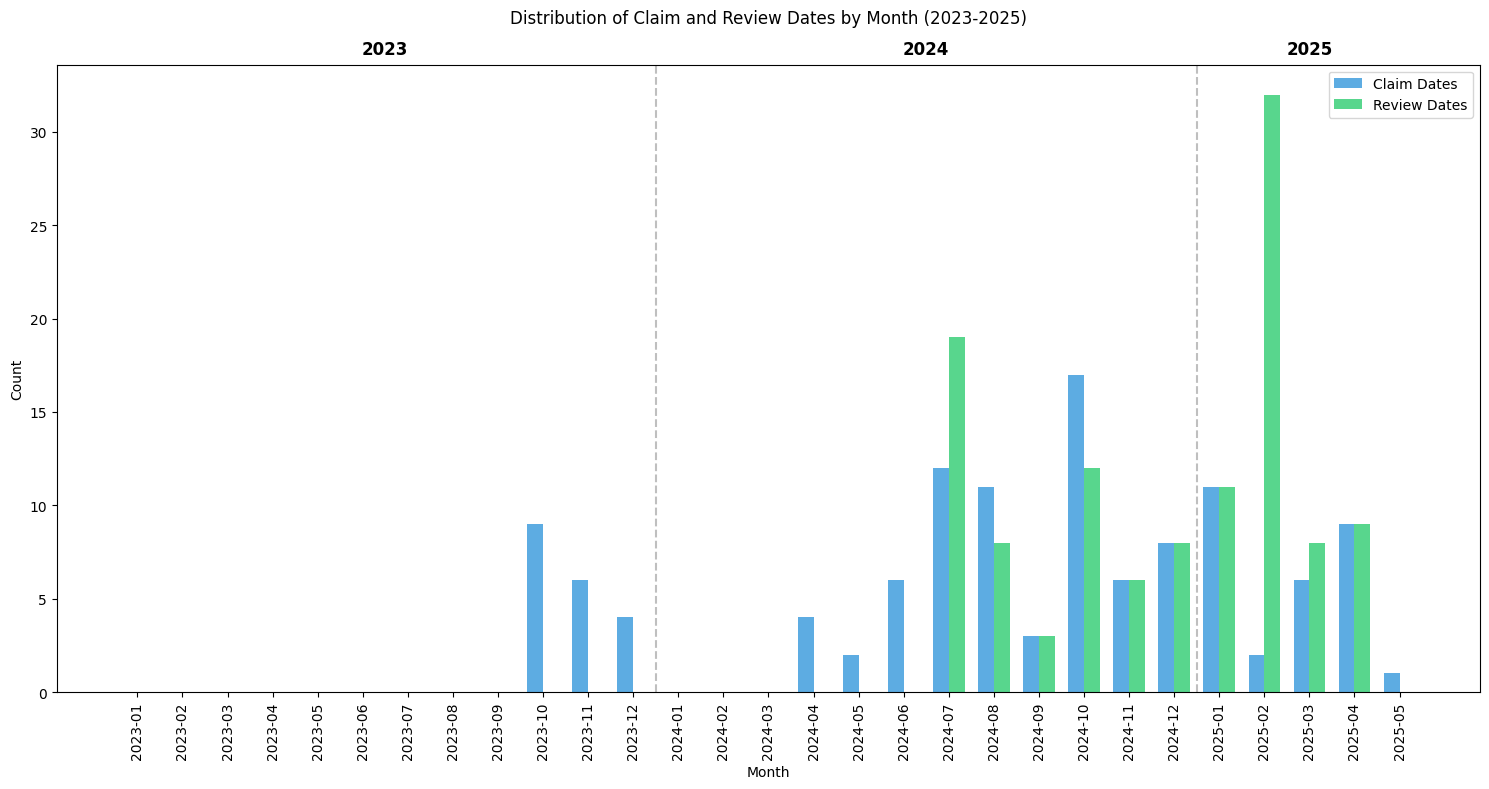

In [82]:
plot_monthly_distribution(df)

In [83]:
df.head()
claim_counts = df.groupby(['claim_year', 'claim_month']).size().reset_index(name="count")
claim_counts

claim_year  claim_month  count
0       2023.0         10.0      9
1       2023.0         11.0      6
2       2023.0         12.0      4
3       2024.0          4.0      4
4       2024.0          5.0      2
5       2024.0          6.0      6
6       2024.0          7.0     12
7       2024.0          8.0     11
8       2024.0          9.0      3
9       2024.0         10.0     17
10      2024.0         11.0      6
11      2024.0         12.0      8
12      2025.0          1.0     11
13      2025.0          2.0      2
14      2025.0          3.0      6
15      2025.0          4.0      9
16      2025.0          5.0      1

- There are 19 claims in 2023 -> filtering them out 
- There are 12 claims in 01-06/2024 -> filtering them out 
- There is 1 claim in 05/2025 -> filtering it out

In [84]:
# Writing a function to filter out claims without a claimDate and claims with a claimDate
## before 07/2024 and after 04/2025

def filter_claims(json_data):

    """ 
    
    This function filters out claims without a claimDate and claims with a claimDate before
    07/2024, since this is the knowledge cutoff of the used MLLM (Gemini 2.0 Flash) and claims before
    are likely part of its training date, and claims with a claimDate after 04/2025, since this 
    is the cutoff date of all collected claims (manually and API). The json might include claims from May,
    because the API collection was run on May, 4th, and the API's maxAgeDays parameter does not allow
    an end date of the claims but scrapes all claims until the date of scraping. 

    Args: The json file that is returned from Google's Fact Check Tools API (Claim Search)
    Returns: The json file filtered by claimDate
    
    """

    # Creating a copy of the original data to avoid modifying it
    data_copy = json_data.copy()

    # Getting the claims
    claims = data_copy.get("claims", [])

    # Add an index to each claim for better tracking
    for i, claim in enumerate(claims):
        claim['index'] = i

    print(f"Original number of claims: {len(claims)}")

    # a) Filter out claims without a claimDate
    claims_with_date = [claim for claim in claims if claim.get("claimDate") is not None]
    print(f"Claims removed due to missing claimDate: {len(claims) - len(claims_with_date)}")

    # b) Filter out claims with claimDate before July 2024 or after April 2025

    lower_cutoff = datetime.strptime("2024-07-01T00:00:00Z", "%Y-%m-%dT%H:%M:%SZ")
    upper_cutoff = datetime.strptime("2025-05-01T00:00:00Z", "%Y-%m-%dT%H:%M:%SZ")

    filtered_claims = []
    claims_before_cutoff = 0
    claims_after_cutoff = 0
    
    for claim in claims_with_date:
        # parse the claim date string to a datetime object
        try:
            claim_date = datetime.strptime(claim["claimDate"], "%Y-%m-%dT%H:%M:%SZ")

            if claim_date < lower_cutoff:
                claims_before_cutoff += 1
                continue
            elif claim_date >= upper_cutoff:
                claims_after_cutoff += 1
                continue 

            # append claims that are within the correct time frame
            filtered_claims.append(claim)
        
        except ValueError:
            print(f"Warning: Could not parse date format for claim {claim.get("index")}: {claim.get("claimDate")}")


    print(f"Claims removed with claimDate before July 2024: {claims_before_cutoff}")
    print(f"Claims removed with claimDate after April 2025: {claims_after_cutoff}")
    print(f"Final numer of claims after filtering: {len(filtered_claims)}")

    # c) Create the filtered json
    data_copy["claims"] = filtered_claims

    ## Display some stats about the filtered claims
    df = pd.DataFrame([(claim.get("index"), claim.get("claimDate"))
                       for claim in filtered_claims], 
                       columns = ["index", "claimDate"])
    
    print("Distribution of remaining claims by year-month:")
    df["claimDate"] = pd.to_datetime(df["claimDate"])
    print(df["claimDate"].dt.strftime("%Y-%m").value_counts().sort_index())

    return data_copy 



In [85]:
json_filtered_date = filter_claims(data)

Original number of claims: 126
Claims removed due to missing claimDate: 9
Claims removed with claimDate before July 2024: 31
Claims removed with claimDate after April 2025: 1
Final numer of claims after filtering: 85
Distribution of remaining claims by year-month:
claimDate
2024-07    12
2024-08    11
2024-09     3
2024-10    17
2024-11     6
2024-12     8
2025-01    11
2025-02     2
2025-03     6
2025-04     9
Name: count, dtype: int64


In [86]:
# Checking that the filtering worked
print(len(json_filtered_date["claims"]))

json_filtered_date

85


{'query': 'Gaza',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'A video shows Pope Francis making his final public address before his death in which he called for a ceasefire in Gaza.',
   'claimant': 'instagram user',
   'claimDate': '2025-04-21T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfact.org'},
     'url': 'https://fullfact.org/news/pope-francis-final-address-gaza-misleading-video/',
     'title': 'Video of Pope’s ‘final public address’ is actually from 2023 – Full Fact',
     'reviewDate': '2025-04-25T00:00:00Z',
     'textualRating': 'The Pope did appeal for a ceasefire in his final address, delivered on Easter Sunday on his behalf by a cardinal, but the video being shared is of a different speech that Pope Francis delivered in December 2023.',
     'languageCode': 'en'}],
   'index': 1},
  {'text': 'Video shows Cristiano Ronaldo voicing support for Gaza',
   'claimant': 'Social Media',
   'claimDate': 

### 2) Remove claims with videos

In [87]:
# Either the "text" or "title" key usually contains a "video"/"Video" string -> using this for filter

# Function to get all samples whose "text" or "title" contain "video" (case-insensitive)

def find_claims_with_videos(json_data):

    """ 
    
    This function finds all claims that either have a "video" string in the "text" key (which 
    contains the claim itself) or the "title" key within the "claimReview" key. The "title" key 
    contains the headline of the fact-checking article of a website. 

    Args: The json file that is filtered by claimDate.
    Returns: An overview of all claims with a "video" string in their "text" or "title" keys.
    
    """
    
    claims_with_videos = []

    # Get claims from the JSON
    claims = json_data.get("claims", [])

    for claim in claims:
        # Check if "video" is in the "text" key (case-insensitive)
        if "text" in claim and "video" in claim["text"].lower():
            claims_with_videos.append(claim)
            continue

        # Check if "video" is in the "title" key of the "claimReview" key (case-insensitive)
        if "claimReview" in claim:
            for review in claim["claimReview"]:
                if "title" in review and "video" in review["title"].lower():
                    claims_with_videos.append(claim)
                    break
    
    print(f"Found {len(claims_with_videos)} claims containing 'video' in text or title")

    # Print the incides of samples with video
    indices = [claim.get("index") for claim in claims_with_videos]
    print(f"Indices of claims with video: {indices}")

    return claims_with_videos


In [88]:
find_claims_with_videos(json_filtered_date)

Found 38 claims containing 'video' in text or title
Indices of claims with video: [1, 2, 7, 8, 9, 14, 16, 18, 22, 27, 28, 30, 31, 33, 34, 35, 38, 41, 43, 48, 49, 51, 52, 61, 62, 64, 65, 67, 71, 74, 75, 78, 79, 80, 83, 84, 86, 93]


[{'text': 'A video shows Pope Francis making his final public address before his death in which he called for a ceasefire in Gaza.',
  'claimant': 'instagram user',
  'claimDate': '2025-04-21T00:00:00Z',
  'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfact.org'},
    'url': 'https://fullfact.org/news/pope-francis-final-address-gaza-misleading-video/',
    'title': 'Video of Pope’s ‘final public address’ is actually from 2023 – Full Fact',
    'reviewDate': '2025-04-25T00:00:00Z',
    'textualRating': 'The Pope did appeal for a ceasefire in his final address, delivered on Easter Sunday on his behalf by a cardinal, but the video being shared is of a different speech that Pope Francis delivered in December 2023.',
    'languageCode': 'en'}],
  'index': 1},
 {'text': 'Video shows Cristiano Ronaldo voicing support for Gaza',
  'claimant': 'Social Media',
  'claimDate': '2025-04-10T00:00:00Z',
  'claimReview': [{'publisher': {'name': 'NewsMobile',
     'site': 'newsmobile.

In [89]:
def filter_out_video_claims(json_data):
    """
    This function filters out claims containing 'video' in text or title fields from the JSON.
    Returns a new JSON without video-related claims.

    Args: The json file that is filtered by claimDate.
    Returns: A new json file that is filtered by claimDate and video-related claims.

    """
    # Create a copy of the original data to avoid modifying it
    data_copy = json_data.copy()
    claims = data_copy.get("claims", [])
    
    # First identify claims with videos (using your existing code)
    claims_with_videos = []
    video_indices = set()  # Use a set for faster lookups
    
    for claim in claims:
        # Check if "video" is in the "text" key (case-insensitive)
        if "text" in claim and "video" in claim["text"].lower():
            claims_with_videos.append(claim)
            video_indices.add(claim.get("index"))
            continue
            
        # Check if "video" is in the "title" key of the "claimReview" key (case-insensitive)
        if "claimReview" in claim:
            for review in claim["claimReview"]:
                if "title" in review and "video" in review["title"].lower():
                    claims_with_videos.append(claim)
                    video_indices.add(claim.get("index"))
                    break
    
    print(f"Found {len(claims_with_videos)} claims containing 'video' in text or title")
    print(f"Indices of claims with video: {list(video_indices)}")
    
    # Now filter out those claims from the original data
    filtered_claims = [claim for claim in claims if claim.get("index") not in video_indices]
    
    print(f"Original number of claims: {len(claims)}")
    print(f"Remaining claims after filtering: {len(filtered_claims)}")
    
    # Update the filtered data with the non-video claims
    data_copy["claims"] = filtered_claims
    
    return data_copy

In [90]:
json_filtered_date_videos = filter_out_video_claims(json_filtered_date)

Found 38 claims containing 'video' in text or title
Indices of claims with video: [1, 2, 7, 8, 9, 14, 16, 18, 22, 27, 28, 30, 31, 33, 34, 35, 38, 41, 43, 48, 49, 51, 52, 61, 62, 64, 65, 67, 71, 74, 75, 78, 79, 80, 83, 84, 86, 93]
Original number of claims: 85
Remaining claims after filtering: 47


In [91]:
# Checking that filtering worked
print(len(json_filtered_date_videos["claims"]))

json_filtered_date_videos

47


{'query': 'Gaza',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Photo shows a Turkey-made bomb that was dropped on Gaza.',
   'claimant': 'x.com',
   'claimDate': '2025-04-18T14:37:44Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/04/18/image-does-not-show-debris-turkish-made-bomb-dropped-gaza',
     'title': 'Image Does Not Show Debris of Turkish-Made Bomb Dropped on Gaza',
     'reviewDate': '2025-04-18T14:37:44Z',
     'textualRating': 'misleading',
     'languageCode': 'en'}],
   'index': 3},
  {'text': 'A US General named John Pagri was killed in Gaza',
   'claimant': 'Multiple authors',
   'claimDate': '2025-04-06T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'AFP Fact Check',
      'site': 'factcheck.afp.com'},
     'url': 'https://factcheck.afp.com/doc.afp.com.42JE3T2',
     'title': 'False claims about US general being killed in Gaza spread online',
     'reviewDat

### 3) Remove all claims from AFP Factcheck, Reuters, Snopes and Politifact

Since I already manually went through the [AFP Factcheck](https://factcheck.afp.com), [Reuters](https://www.reuters.com/fact-check), [Snopes](https://snopes.com/fact-check) and [Politifact](https://www.politifact.com/factchecks/) fact checking websites to collect text-only claims and claims with images for Gaza, Israel, Ukraine and Russia in the respective time frame (07/24 - 04/25), I will filter out all claims with from one of those websites in the json. 

Claims in the json_filtered_date_videos with:

- AFP Factcheck: 8 (https://factcheck.afp.com)
- Politifact: 1 (https://politifact.com/factchecks)
- Reuters: 0 (https://reuters.com/fact-check)
- Snopes: 0 (https://snopes.com/fact-check)

In [92]:
# Set the URLs of the fact-checking websites

afp_factcheck = "https://factcheck.afp.com"
reuters = "https://reuters.com/fact-check"
snopes = "https://snopes.com/fact-check"
politifact = "https://politifact.com/factchecks"



def filter_claims_by_websites(json_data):

    """ 
    
    This function filters out those claims that have been fact-checked by AFP Factcheck, Reuters,
    Snopes or Politifact, since these websites have already been part of the manual data collection. 
    The code uses regex to match the URLs.

    Args: The json file that has been filtered by date and video-related claims.
    Returns: The json file filtered by date, video, and fact checking websites.
    
    """

    # Create a copy of the original data to avoid modifying it
    data_copy = json_data.copy()

    # Define the fact-checking websites URLs
    domains = [
        r"factcheck\.afp\.com",
        r"reuters\.com/fact-check",
        r"snopes\.com/fact-check",
        r"politifact\.com/factchecks"
    ]

    # Create flexible regex pattern that works with or without www
    patterns = [rf"https?://(?:www\.)?{domain}" for domain in domains]
    pattern = '|'.join(patterns) #join the patterns
    url_regex = re.compile(pattern) #compiles the string into regex pattern object

    # Create empty list to store filtered claims
    filtered_claims = []

    # Process each claim 
    for claim in json_data.get("claims", []):
        for review in claim.get("claimReview", []):
            # Extract url and check if it matches any target url
            url = review.get("url", "")

            if url_regex.search(url): #looking for exact match
                filtered_claims.append(claim)
                break 

    # Print out the filtered claims for an overview and manual verification
    print(f"Found {len(filtered_claims)} claims with target fact-checking websites.")
    for claim in filtered_claims:
        print(claim)

    # Remove the filtered claims from the copied json
    if "claims" in data_copy:
        # keep only claims not in filtered_claims
        data_copy["claims"] = [claim for claim in data_copy["claims"]
                               if claim not in filtered_claims]
        
    return data_copy

In [93]:
json_filtered_date_videos_urls = filter_claims_by_websites(json_filtered_date_videos)

Found 10 claims with target fact-checking websites.
{'text': 'A US General named John Pagri was killed in Gaza', 'claimant': 'Multiple authors', 'claimDate': '2025-04-06T00:00:00Z', 'claimReview': [{'publisher': {'name': 'AFP Fact Check', 'site': 'factcheck.afp.com'}, 'url': 'https://factcheck.afp.com/doc.afp.com.42JE3T2', 'title': 'False claims about US general being killed in Gaza spread online', 'reviewDate': '2025-04-17T16:57:00Z', 'textualRating': 'False', 'languageCode': 'en'}], 'index': 4}
{'text': "Genuine photo of mother embracing son's skeleton in Gaza", 'claimant': 'Multiple Sources', 'claimDate': '2025-03-24T00:00:00Z', 'claimReview': [{'publisher': {'name': 'AFP Fact Check', 'site': 'factcheck.afp.com'}, 'url': 'https://factcheck.afp.com/doc.afp.com.37W26WD', 'title': "Image of 'Gazan mother with son's bones' is made with AI", 'reviewDate': '2025-03-27T04:15:00Z', 'textualRating': 'AI-generated', 'languageCode': 'en'}], 'index': 10}
{'text': 'Photos show Myanmar earthquake

In [94]:
#Verify the length of the json and manually inspect the json to ensure the filtering was successful
print(len(json_filtered_date_videos_urls["claims"])) 
json_filtered_date_videos_urls

37


{'query': 'Gaza',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Photo shows a Turkey-made bomb that was dropped on Gaza.',
   'claimant': 'x.com',
   'claimDate': '2025-04-18T14:37:44Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/04/18/image-does-not-show-debris-turkish-made-bomb-dropped-gaza',
     'title': 'Image Does Not Show Debris of Turkish-Made Bomb Dropped on Gaza',
     'reviewDate': '2025-04-18T14:37:44Z',
     'textualRating': 'misleading',
     'languageCode': 'en'}],
   'index': 3},
  {'text': 'Baby Sham did not lose her arm in an Israeli airstrike on the Shejaeya neighborhood, east of Gaza City.',
   'claimant': 'x.com',
   'claimDate': '2025-04-13T05:39:22Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/04/13/contrary-trolls-baby-sham-lost-her-arm-and-died-israeli-airstrike',
     'title': 'Contrary t

### 4) Remove claims that don't have a clear, short label (maximum of 3 words/tokens)


- The label length distribution in the manual datasets is between 1 and a maximum of three words: 

  - 1 word, e.g.,: True, false, misleading, unproven
  - 2 words, e.g.,: No evidence, correct attribution
  - 3 words, e.g.,: Originated as satire

- The threshold of maximum three words will also be applied to the jsons here


In [112]:
def extract_textual_ratings(json_data):

    """ 
    This function extracts the textual ratings and its length (word count) for each claim and stores it in a list of dictionaries
    which are then used to visualize the word count distribution and filter out claims which have a too long label.
    
    """

    label_word_counts = []

    for claim in json_data.get("claims", []):
        for review in claim.get("claimReview", []):
            textual_rating = review.get("textualRating", [])
            label_word_count = len(textual_rating.split())
            label_word_counts.append(label_word_count)

    return label_word_counts


def visualize_textual_ratings_length(json_data):

    # Extract textual ratings

    label_word_counts = extract_textual_ratings(json_data)

    # # Convert to df for easier analysis 
    # df = pd.DataFrame(label_word_counts)

    # Count frequencies of word counts
    word_count_freq = Counter(label_word_counts)

    # Sort by word count for better visualization
    word_counts = sorted(word_count_freq.keys())
    frequencies = [word_count_freq[count] for count in word_counts]

    # Plot word count distribution
    plt.figure(figsize=(12,6))
    plt.bar(word_counts, frequencies, color="skyblue")
    plt.title("Distribution of the claim labels' length in words")
    plt.xlabel("Word count")
    plt.ylabel("Frequency")


    plt.tight_layout()
    plt.show()



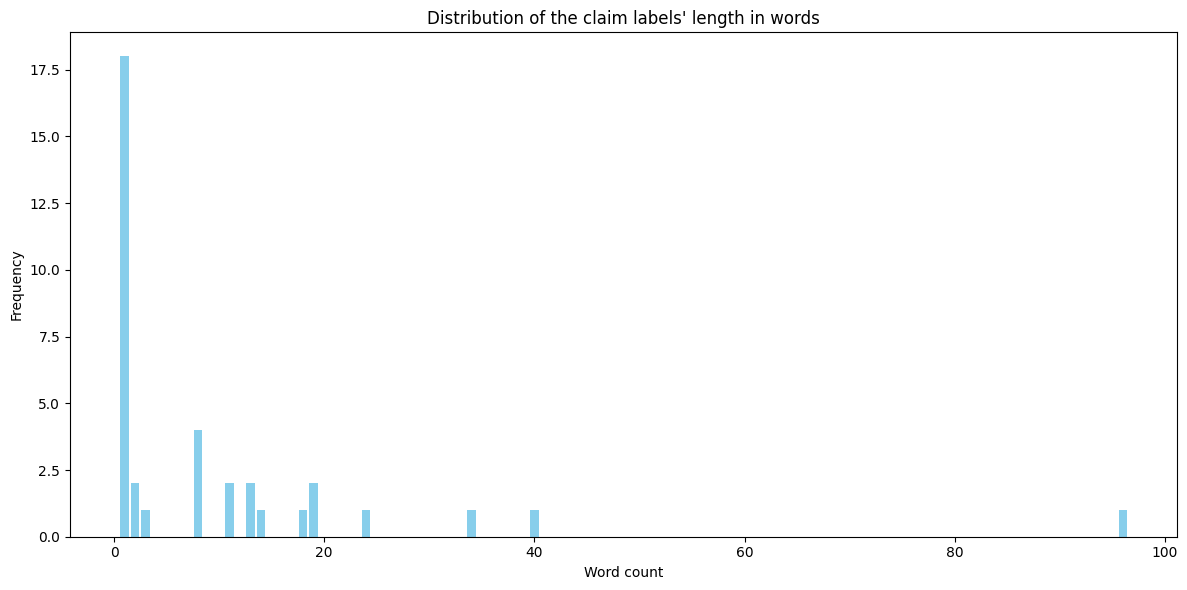

In [113]:
visualize_textual_ratings_length(json_filtered_date_videos_urls)

In [124]:
### Remove the claims whose labels have more than 3 words


def filter_claims_by_label_length(json_data, max_words=3):

    """ 
    
    This function remove all the claims whose labels are too long, i.e. labels that have more than three words.
    
    """

    # Create a copy of the original data to avoid modifying it
    data_copy = json_data.copy()


    # Filter claims
    filtered_claims = []
    removed_count = 0

    for claim in json_data.get("claims", []):
        keep_claim = True

        # Check the label for the claim
        for review in claim.get("claimReview", []):
            textual_rating = review.get("textualRating", [])
            label_word_count = len(textual_rating.split())

            # If a review has a label that's too long, don't keep it
            if label_word_count > max_words:
                keep_claim = False
                break

        # Add to filtered list or increment removed count
        if keep_claim:
            filtered_claims.append(claim)
        else:
            removed_count += 1

    # Replace claims in the copied data
    data_copy["claims"] = filtered_claims

    print(f"Removed {removed_count} claims whose labels are longer than {max_words} words")
    print(f"Kept {len(filtered_claims)} claims whose labels are of {max_words} or fewer words")

    return data_copy


In [125]:
json_filtered_date_videos_urls_labels = filter_claims_by_label_length(json_filtered_date_videos_urls, max_words = 3)

# Checking the length of the claims and manually inspecting it to make sure the filtering was done correctly
print(len(json_filtered_date_videos_urls_labels["claims"]))
json_filtered_date_videos_urls_labels

Removed 16 claims whose labels are longer than 3 words
Kept 21 claims whose labels are of 3 or fewer words
21


{'query': 'Gaza',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Photo shows a Turkey-made bomb that was dropped on Gaza.',
   'claimant': 'x.com',
   'claimDate': '2025-04-18T14:37:44Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/04/18/image-does-not-show-debris-turkish-made-bomb-dropped-gaza',
     'title': 'Image Does Not Show Debris of Turkish-Made Bomb Dropped on Gaza',
     'reviewDate': '2025-04-18T14:37:44Z',
     'textualRating': 'misleading',
     'languageCode': 'en'}],
   'index': 3},
  {'text': 'Baby Sham did not lose her arm in an Israeli airstrike on the Shejaeya neighborhood, east of Gaza City.',
   'claimant': 'x.com',
   'claimDate': '2025-04-13T05:39:22Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/04/13/contrary-trolls-baby-sham-lost-her-arm-and-died-israeli-airstrike',
     'title': 'Contrary t

### 5) Remove duplicates within the jsons 

- exact duplicates
- non-exact duplicates (same content, but claims are formulated differently)
  - manual inspection
  - prompting LLMs (using in-context learning examples -> 1 True, 1 False)
  - embedding-based approach (LLMs)

#### 5.1) Remove exact duplicates

In [126]:

def remove_exact_duplicate_claims(json_data):

    """ 
    
    This function removes exact duplicate claims from the JSON file based on the "text" field.

    Args:
    Returns:
    
    
    """

    # Create a copy of the original data to avoid modifying it
    data_copy = json_data.copy()

    # Create dictionary and list to store seen/unique claims
    seen_texts = {}
    unique_claims = []

    # Create list to store duplicate claims
    duplicate_texts = []

    # Loop through each claim
    for claim in json_data.get("claims", []):
        claim_text = claim.get("text", "")

        # If we have seen this text before, it's a duplicate
        if claim_text in seen_texts:
            duplicate_texts.append(claim_text)
        else:
            # If we see a text the first time, we add it to our tracking and unique claims list
            seen_texts[claim_text] = True
            unique_claims.append(claim)

    # Print duplicate claims for an overview and verification
    if duplicate_texts:
        print(f"Found {len(duplicate_texts)} duplicate claims:")
        for text in duplicate_texts:
            print(text)

    # Update the copied json with the unique claims to remove duplicates
    data_copy["claims"] = unique_claims

    return data_copy 

    

In [127]:
json_filtered_date_videos_urls_labels_duplic_exact = remove_exact_duplicate_claims(json_filtered_date_videos_urls_labels)

#Verify the length of the json and manually inspect the json to ensure the filtering was successful
print(len(json_filtered_date_videos_urls_labels_duplic_exact["claims"])) 
json_filtered_date_videos_urls_labels_duplic_exact

Found 4 duplicate claims:
A viral tweet claims that Hamas fighters successfully ambushed an Israeli tank unit near Jabalia camp in northern Gaza, destroying multiple vehicles and injuring or killing their crews.
Social media posts claiming to show recent Israeli attack on Lebanon.
This photo shows a man from Gaza holding the hand of his son killed in an Israeli bombing.
Mercava Pride Zionist Industry Laundry clothesline in Gaza.
17


{'query': 'Gaza',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Photo shows a Turkey-made bomb that was dropped on Gaza.',
   'claimant': 'x.com',
   'claimDate': '2025-04-18T14:37:44Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/04/18/image-does-not-show-debris-turkish-made-bomb-dropped-gaza',
     'title': 'Image Does Not Show Debris of Turkish-Made Bomb Dropped on Gaza',
     'reviewDate': '2025-04-18T14:37:44Z',
     'textualRating': 'misleading',
     'languageCode': 'en'}],
   'index': 3},
  {'text': 'Baby Sham did not lose her arm in an Israeli airstrike on the Shejaeya neighborhood, east of Gaza City.',
   'claimant': 'x.com',
   'claimDate': '2025-04-13T05:39:22Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/04/13/contrary-trolls-baby-sham-lost-her-arm-and-died-israeli-airstrike',
     'title': 'Contrary t

In [128]:
# Saving the filtered Gaza json 

output_directory = "../gaza_israel/API_data_collection/API-fact-tools-google/"
output_filename = "claims_gaza_010724_040525_filtered_17_claims.json"

output_path = os.path.join(output_directory, output_filename)


with open(output_path, "w", encoding = "utf-8") as f:
    json.dump(json_filtered_date_videos_urls_labels_duplic_exact, f, ensure_ascii=False, indent=4)


#### 5.2) Removing non-exact duplicates (same content, but claims are formulated differently) -> Notebook "claims_preprocessing_embedding_LLM.ipynb"

- Using Embedding-Based Approach
- Using LLM Prompting -> Vgl. Template GraphRAG Exam & Internship Python Files
- Using Manual Verification (index 19& 20 & 21, evtl index 58 & 59)

## 2) Israel

### 1) Remove claims after April, 30th, 2025 and (if availabe) before July, 1st, 2024

In [129]:
file_path = "../gaza_israel/API_data_collection/API-fact-tools-google/claims_israel_en_010724_040525_501_claims.json"

try:
    with open(file_path, "r", encoding = "utf-8") as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

In [130]:
data

{'query': 'Israel',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Image shows wildfires in Israel burning roads, high-rise towers and other buildings.',
   'claimant': 'Social Media Users',
   'claimDate': '2025-05-03T10:39:05Z',
   'claimReview': [{'publisher': {'name': 'NewsMeter', 'site': 'newsmeter.in'},
     'url': 'https://newsmeter.in/fact-check/roads-and-highrise-towers-burning-in-israel-no-viral-image-is-ai-generated-747851',
     'title': 'Fact Check: Roads and high-rise towers burning in Israel? No, viral image is AI generated',
     'reviewDate': '2025-05-03T10:39:05Z',
     'textualRating': 'False',
     'languageCode': 'en'}]},
  {'text': 'Israel is facing the real wrath of God in a single day. As the wildfire spreads massively, a sandstorm has hit Israel.',
   'claimant': 'x.com',
   'claimDate': '2025-05-04T05:21:35Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/05/

In [131]:
df_israel = extract_claim_and_reviewDate_from_json_transform_to_df(json_data = data)

Checking data types for a sample of the data:

Item 1:
  claimDate: 2025-05-03T10:39:05Z (Type: str)
  reviewDate: 2025-05-03T10:39:05Z (Type: str)

Item 2:
  claimDate: 2025-05-04T05:21:35Z (Type: str)
  reviewDate: 2025-05-04T05:21:35Z (Type: str)

Item 3:
  claimDate: 2025-05-04T05:35:38Z (Type: str)
  reviewDate: 2025-05-04T05:35:38Z (Type: str)

Item 4:
  claimDate: 2025-05-01T12:46:18Z (Type: str)
  reviewDate: 2025-05-01T12:46:18Z (Type: str)

Item 5:
  claimDate: 2025-04-24T00:00:00Z (Type: str)
  reviewDate: 2025-05-01T11:36:00Z (Type: str)

Length of dataframe:
501

Checking data types again:
claimDate     object
reviewDate    object
dtype: object

NA Values in claim and reviewDate:
claimDate     38
reviewDate    41
dtype: int64

Data types after conversion:
claimDate     datetime64[ns, UTC]
reviewDate    datetime64[ns, UTC]
dtype: object

Missing values after conversion:
claimDate     38
reviewDate    41
dtype: int64


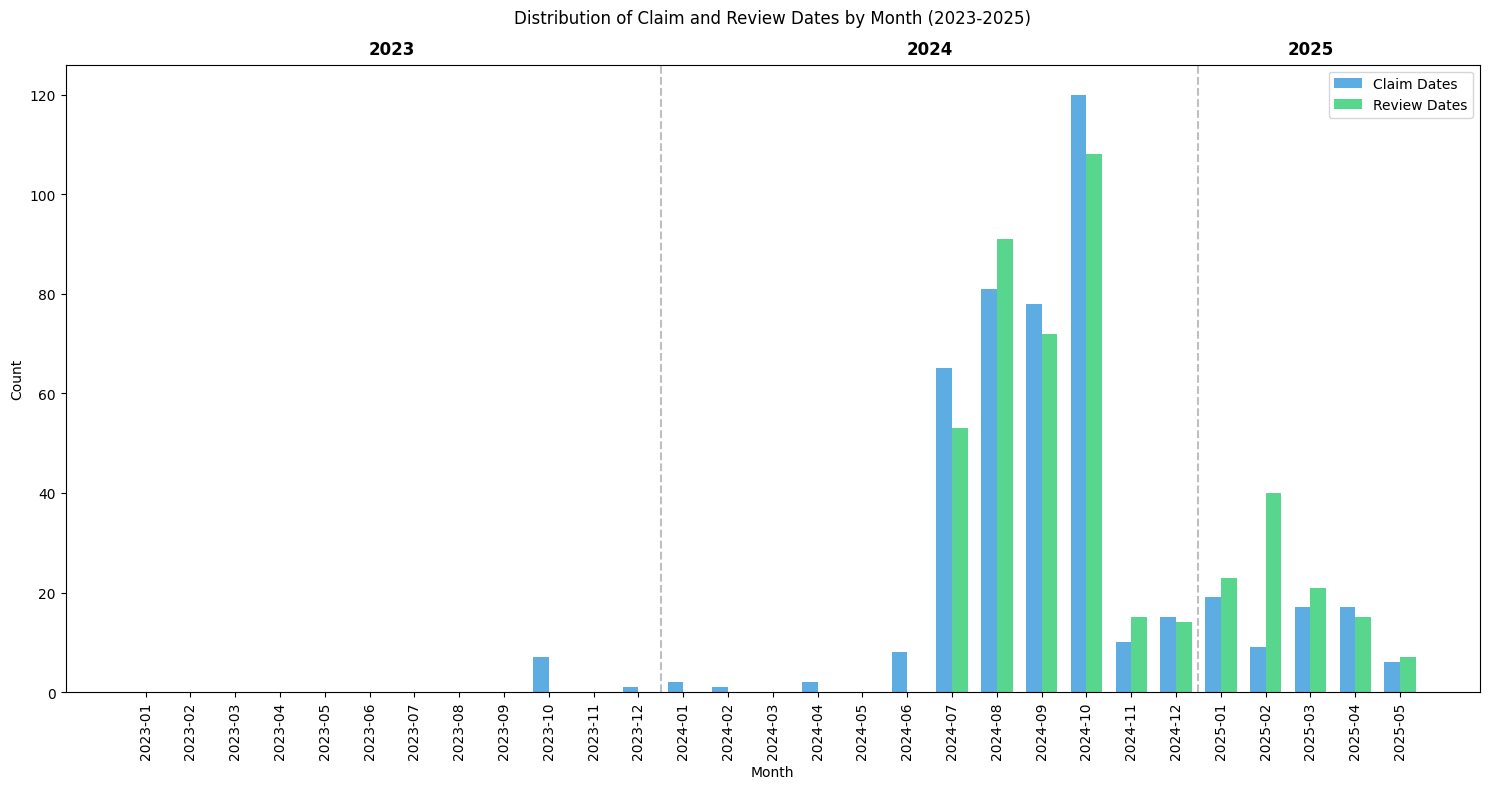

In [132]:
plot_monthly_distribution(df_israel)

In [133]:
claim_counts = df_israel.groupby(['claim_year', 'claim_month']).size().reset_index(name="count")
claim_counts

claim_year  claim_month  count
0       2016.0          6.0      4
1       2021.0         10.0      1
2       2023.0         10.0      7
3       2023.0         12.0      1
4       2024.0          1.0      2
5       2024.0          2.0      1
6       2024.0          4.0      2
7       2024.0          6.0      8
8       2024.0          7.0     65
9       2024.0          8.0     81
10      2024.0          9.0     78
11      2024.0         10.0    120
12      2024.0         11.0     10
13      2024.0         12.0     15
14      2025.0          1.0     19
15      2025.0          2.0      9
16      2025.0          3.0     17
17      2025.0          4.0     17
18      2025.0          5.0      6

- There are 5 claims in 2016 + 2021
- There are 8 claims in 2023 -> filtering them out 
- There are 13 claims in 01-06/2024 -> filtering them out 
- There are 6 claims in 05/2025 -> filtering themn out

In [134]:
json_filtered_date = filter_claims(data)

Original number of claims: 501
Claims removed due to missing claimDate: 38
Claims removed with claimDate before July 2024: 26
Claims removed with claimDate after April 2025: 6
Final numer of claims after filtering: 431
Distribution of remaining claims by year-month:
claimDate
2024-07     65
2024-08     81
2024-09     78
2024-10    120
2024-11     10
2024-12     15
2025-01     19
2025-02      9
2025-03     17
2025-04     17
Name: count, dtype: int64


In [135]:
# Checking that the filtering worked
print(len(json_filtered_date["claims"]))

json_filtered_date

431


{'query': 'Israel',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Video shows massive blaze in central Israel, April 2025',
   'claimant': 'Multiple sources',
   'claimDate': '2025-04-24T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'AFP Fact Check',
      'site': 'factcheck.afp.com'},
     'url': 'https://factcheck.afp.com/doc.afp.com.43Z48G2',
     'title': 'Video shows wildfire in Los Angeles, not Israel',
     'reviewDate': '2025-05-01T11:36:00Z',
     'textualRating': 'False',
     'languageCode': 'en'}],
   'index': 4},
  {'text': 'No, Israeli Embassy did not issue note verbale to MEA alleging sexual assault by senior Indian Army official; details inside',
   'claimant': 'PTI Fact Check',
   'claimDate': '2025-04-30T15:04:01Z',
   'claimReview': [{'publisher': {'name': 'PTI', 'site': 'ptinews.com'},
     'url': 'https://www.ptinews.com/fact-detail/pti-fact-check-no-israeli-embassy-did-not-issue-note-verbale-to-mea-alleging-sexual-ass

### 2) Remove claims with videos

In [136]:
find_claims_with_videos(json_filtered_date)

Found 225 claims containing 'video' in text or title
Indices of claims with video: [4, 8, 9, 11, 13, 14, 17, 23, 26, 29, 31, 32, 33, 34, 35, 39, 40, 42, 43, 53, 55, 57, 59, 60, 61, 64, 66, 67, 68, 69, 70, 72, 79, 80, 81, 82, 83, 84, 86, 88, 91, 95, 98, 99, 100, 101, 102, 106, 109, 112, 113, 117, 118, 120, 122, 123, 124, 125, 126, 128, 131, 135, 137, 141, 145, 146, 150, 152, 153, 156, 160, 161, 163, 168, 169, 172, 173, 174, 176, 177, 178, 182, 183, 184, 186, 188, 189, 190, 191, 193, 195, 196, 197, 199, 200, 201, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226, 228, 229, 231, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 247, 248, 249, 250, 251, 254, 255, 256, 257, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 270, 271, 272, 273, 274, 277, 278, 279, 281, 282, 283, 284, 285, 288, 290, 293, 296, 298, 299, 302, 303, 305, 306, 308, 311, 312, 314, 317, 318, 319, 322, 323, 324, 326, 331, 345, 348, 349, 351, 354, 356, 358, 359

[{'text': 'Video shows massive blaze in central Israel, April 2025',
  'claimant': 'Multiple sources',
  'claimDate': '2025-04-24T00:00:00Z',
  'claimReview': [{'publisher': {'name': 'AFP Fact Check',
     'site': 'factcheck.afp.com'},
    'url': 'https://factcheck.afp.com/doc.afp.com.43Z48G2',
    'title': 'Video shows wildfire in Los Angeles, not Israel',
    'reviewDate': '2025-05-01T11:36:00Z',
    'textualRating': 'False',
    'languageCode': 'en'}],
  'index': 4},
 {'text': 'Video of 2024 Israeli strikes on southern Lebanon and Beirut’s outskirts falsely shared as Indian Army action after Pahalgam terror attack',
  'claimant': 'PTI Fact Check',
  'claimDate': '2025-04-28T13:04:26Z',
  'claimReview': [{'publisher': {'name': 'PTI', 'site': 'ptinews.com'},
    'url': 'https://www.ptinews.com/fact-detail/pti-fact-check-video-of-2024-israeli-strikes-on-southern-lebanon-and-beirut-s-outskirts-falsely-shared-as-indian-army-action-after-pahalgam-terror-attack/2505890',
    'title': 'PTI 

In [137]:
json_filtered_date_videos = filter_out_video_claims(json_filtered_date)

Found 225 claims containing 'video' in text or title
Indices of claims with video: [4, 8, 9, 11, 13, 14, 17, 23, 26, 29, 31, 32, 33, 34, 35, 39, 40, 42, 43, 53, 55, 57, 59, 60, 61, 64, 66, 67, 68, 69, 70, 72, 79, 80, 81, 82, 83, 84, 86, 88, 91, 95, 98, 99, 100, 101, 102, 106, 109, 112, 113, 117, 118, 120, 122, 123, 124, 125, 126, 128, 131, 135, 137, 141, 145, 146, 150, 152, 153, 156, 160, 161, 163, 168, 169, 172, 173, 174, 176, 177, 178, 182, 183, 184, 186, 188, 189, 190, 191, 193, 195, 196, 197, 199, 200, 201, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226, 228, 229, 231, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 247, 248, 249, 250, 251, 254, 255, 256, 257, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 270, 271, 272, 273, 274, 277, 278, 279, 281, 282, 283, 284, 285, 288, 290, 293, 296, 298, 299, 302, 303, 305, 306, 308, 311, 312, 314, 317, 318, 319, 322, 323, 324, 326, 331, 345, 348, 349, 351, 354, 356, 358, 359

In [138]:
# Checking that filtering worked
print(len(json_filtered_date_videos["claims"]))

json_filtered_date_videos

206


{'query': 'Israel',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'No, Israeli Embassy did not issue note verbale to MEA alleging sexual assault by senior Indian Army official; details inside',
   'claimant': 'PTI Fact Check',
   'claimDate': '2025-04-30T15:04:01Z',
   'claimReview': [{'publisher': {'name': 'PTI', 'site': 'ptinews.com'},
     'url': 'https://www.ptinews.com/fact-detail/pti-fact-check-no-israeli-embassy-did-not-issue-note-verbale-to-mea-alleging-sexual-assault-by-senior-indian-army-official-details-inside/2512610',
     'title': 'PTI Fact Check: No, Israeli Embassy did not issue note verbale to MEA alleging sexual assault by senior Indian Army official; details inside',
     'textualRating': 'False',
     'languageCode': 'en'}],
   'index': 7},
  {'text': 'Breaking News: Fires broke out in several places across Israel due to the extreme heat that befell us.',
   'claimant': 'x.com',
   'claimDate': '2025-04-26T15:11:42Z',
   'claimR

### 3) Remove all claims from AFP Factcheck, Reuters, Snopes and Politifact

In [139]:
json_filtered_date_videos_urls = filter_claims_by_websites(json_filtered_date_videos)

Found 24 claims with target fact-checking websites.
{'text': 'Duterte suggested ICC put ex-US and Israeli leaders on trial during hearing', 'claimant': 'Multiple sources', 'claimDate': '2025-03-23T00:00:00Z', 'claimReview': [{'publisher': {'name': 'AFP Fact Check', 'site': 'factcheck.afp.com'}, 'url': 'https://factcheck.afp.com/doc.afp.com.37LY8G2', 'title': "Posts share fabricated record of former Philippine president 'refuting ICC charges'", 'reviewDate': '2025-03-25T09:56:00Z', 'textualRating': 'False', 'languageCode': 'en'}], 'index': 28}
{'text': "Photo shows Israeli settlers in Thailand's Pai in 2025", 'claimant': 'Multiple sources', 'claimDate': '2025-02-16T00:00:00Z', 'claimReview': [{'publisher': {'name': 'AFP Fact Check', 'site': 'factcheck.afp.com'}, 'url': 'https://factcheck.afp.com/doc.afp.com.36XY2FV', 'title': "Old image misrepresented as 'Israeli settlers' in northern Thailand after Gaza ceasefire", 'reviewDate': '2025-02-19T10:39:00Z', 'textualRating': 'False', 'langua

In [140]:
#Verify the length of the json and manually inspect the json to ensure the filtering was successful
print(len(json_filtered_date_videos_urls["claims"])) 
json_filtered_date_videos_urls

182


{'query': 'Israel',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'No, Israeli Embassy did not issue note verbale to MEA alleging sexual assault by senior Indian Army official; details inside',
   'claimant': 'PTI Fact Check',
   'claimDate': '2025-04-30T15:04:01Z',
   'claimReview': [{'publisher': {'name': 'PTI', 'site': 'ptinews.com'},
     'url': 'https://www.ptinews.com/fact-detail/pti-fact-check-no-israeli-embassy-did-not-issue-note-verbale-to-mea-alleging-sexual-assault-by-senior-indian-army-official-details-inside/2512610',
     'title': 'PTI Fact Check: No, Israeli Embassy did not issue note verbale to MEA alleging sexual assault by senior Indian Army official; details inside',
     'textualRating': 'False',
     'languageCode': 'en'}],
   'index': 7},
  {'text': 'Breaking News: Fires broke out in several places across Israel due to the extreme heat that befell us.',
   'claimant': 'x.com',
   'claimDate': '2025-04-26T15:11:42Z',
   'claimR

### 4) Remove claims that don't have a clear, short label (maximum of 3 words/tokens)

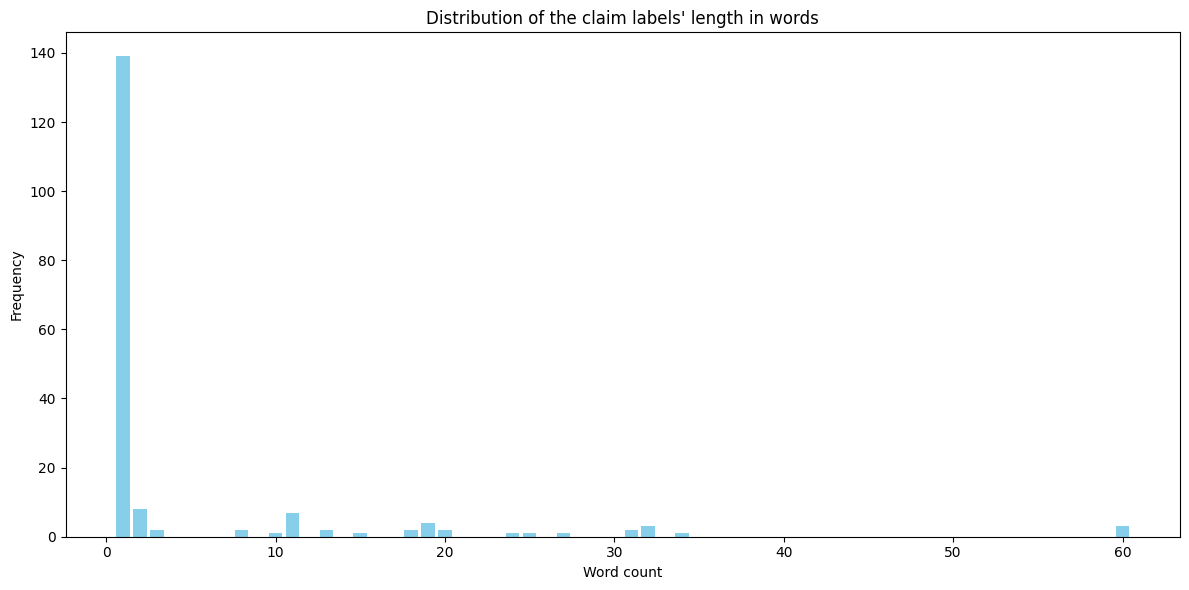

In [141]:
visualize_textual_ratings_length(json_filtered_date_videos_urls)

In [142]:
json_filtered_date_videos_urls_labels = filter_claims_by_label_length(json_filtered_date_videos_urls, max_words = 3)

# Checking the length of the claims and manually inspecting it to make sure the filtering was done correctly
print(len(json_filtered_date_videos_urls_labels["claims"]))
json_filtered_date_videos_urls_labels

Removed 33 claims whose labels are longer than 3 words
Kept 149 claims whose labels are of 3 or fewer words
149


{'query': 'Israel',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'No, Israeli Embassy did not issue note verbale to MEA alleging sexual assault by senior Indian Army official; details inside',
   'claimant': 'PTI Fact Check',
   'claimDate': '2025-04-30T15:04:01Z',
   'claimReview': [{'publisher': {'name': 'PTI', 'site': 'ptinews.com'},
     'url': 'https://www.ptinews.com/fact-detail/pti-fact-check-no-israeli-embassy-did-not-issue-note-verbale-to-mea-alleging-sexual-assault-by-senior-indian-army-official-details-inside/2512610',
     'title': 'PTI Fact Check: No, Israeli Embassy did not issue note verbale to MEA alleging sexual assault by senior Indian Army official; details inside',
     'textualRating': 'False',
     'languageCode': 'en'}],
   'index': 7},
  {'text': 'Breaking News: Fires broke out in several places across Israel due to the extreme heat that befell us.',
   'claimant': 'x.com',
   'claimDate': '2025-04-26T15:11:42Z',
   'claimR

### 5) Remove duplicates within the jsons 

- exact duplicates
- non-exact duplicates (same content, but claims are formulated differently)
  - manual inspection
  - prompting LLMs (using in-context learning examples -> 1 True, 1 False)
  - embedding-based approach (LLMs)

#### 5.1) Remove exact duplicates

In [143]:
json_filtered_date_videos_urls_labels_duplic_exact = remove_exact_duplicate_claims(json_filtered_date_videos_urls_labels)

#Verify the length of the json and manually inspect the json to ensure the filtering was successful
print(len(json_filtered_date_videos_urls_labels_duplic_exact["claims"])) 
json_filtered_date_videos_urls_labels_duplic_exact

Found 61 duplicate claims:
Hamas returned the hostages bodies to Israel in locked coffins with keys that do not open them.
Donald Trump's election led Hamas to call "for 'Immediate' End to War."
Netanyahu’s son Yair was killed in a drone attack that targeted the Israeli PM’s home in Caesarea, Israel.
Trump post urged retaliation against Israel if he's assassinated
BREAKING: The UK has announced sanctions against several Iranian senior military figures and organisations following Iran's multiple rocket attack on Israel on 1 October.
Israel has targeted *FRENCH* Multinational Company TotalEnergies gas station in Beirut. This comes after Emmanuel Macron BANNED military aid to Israel.
Fact check: ICJ did not declare Israel an illegal state
ICJ declared Israel as an unlawful state.
Israel has targeted *FRENCH* Multinational Company TotalEnergies gas station in Beirut. This comes after Emmanuel Macron BANNED military aid to Israel.
A post made on X claims that Israel experienced an earthquak

{'query': 'Israel',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'No, Israeli Embassy did not issue note verbale to MEA alleging sexual assault by senior Indian Army official; details inside',
   'claimant': 'PTI Fact Check',
   'claimDate': '2025-04-30T15:04:01Z',
   'claimReview': [{'publisher': {'name': 'PTI', 'site': 'ptinews.com'},
     'url': 'https://www.ptinews.com/fact-detail/pti-fact-check-no-israeli-embassy-did-not-issue-note-verbale-to-mea-alleging-sexual-assault-by-senior-indian-army-official-details-inside/2512610',
     'title': 'PTI Fact Check: No, Israeli Embassy did not issue note verbale to MEA alleging sexual assault by senior Indian Army official; details inside',
     'textualRating': 'False',
     'languageCode': 'en'}],
   'index': 7},
  {'text': 'Breaking News: Fires broke out in several places across Israel due to the extreme heat that befell us.',
   'claimant': 'x.com',
   'claimDate': '2025-04-26T15:11:42Z',
   'claimR

In [144]:
# Saving the filtered Israel json 

output_directory = "../gaza_israel/API_data_collection/API-fact-tools-google/"
output_filename = "claims_israel_010724_040525_filtered_88_claims.json"

output_path = os.path.join(output_directory, output_filename)


with open(output_path, "w", encoding = "utf-8") as f:
    json.dump(json_filtered_date_videos_urls_labels_duplic_exact, f, ensure_ascii=False, indent=4)


### 6) Remove duplicates between the manual data collection and API data collection (maybe do this for Gaza + Israel API jsons together, there could be similar/the same claims within the Gaza and Israel jsons)

#### 6.1) Embedding-based approach (embedding claims and looking for highest cosine similarity)

#### 6.2) LLM-based approach (prompting LLM with in-context examples -> in-context learning)

### 7) Manually comparing the API claims with the manually collected claims

### 8) Visualizing the claim distributions (Vgl. claims_visualization folder)

## 3) Ukraine

### 1) Remove claims after April, 30th, 2025 and (if availabe) before July, 1st, 2024

In [145]:
file_path = "../ukraine_russia/API_data_collection/claims_ukraine_010724_040525_340_claims.json"

try:
    with open(file_path, "r", encoding = "utf-8") as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

In [146]:
data

{'query': 'Ukraine',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'A video shows Russian president Vladimir Putin laughing with his face in his hands during a comedy routine in which Volodymyr Zelenskyy appears to play the piano with his penis, before he became president of Ukraine.',
   'claimant': 'Instagram user',
   'claimDate': '2025-04-13T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfact.org'},
     'url': 'https://fullfact.org/online/Zelenskyy-performing-for-Putin-false/',
     'title': 'Clip does not show Zelenskyy performing comedy routine for Putin – Full Fact',
     'reviewDate': '2025-04-30T00:00:00Z',
     'textualRating': 'False. These two clips are from different events and have been edited together to misleadingly make it appear as if President Putin was in the audience for the routine.',
     'languageCode': 'en'}]},
  {'text': 'After Prince Harry visited Ukraine, the video with the BBC logo spre

In [147]:
df_ukraine = extract_claim_and_reviewDate_from_json_transform_to_df(json_data = data)

Checking data types for a sample of the data:

Item 1:
  claimDate: 2025-04-13T00:00:00Z (Type: str)
  reviewDate: 2025-04-30T00:00:00Z (Type: str)

Item 2:
  claimDate: 2025-04-10T00:00:00Z (Type: str)
  reviewDate: 2025-04-30T00:00:00Z (Type: str)

Item 3:
  claimDate: 2025-04-20T00:00:00Z (Type: str)
  reviewDate: 2025-04-29T00:00:00Z (Type: str)

Item 4:
  claimDate: 2025-04-25T08:02:37Z (Type: str)
  reviewDate: 2025-04-25T08:02:37Z (Type: str)

Item 5:
  claimDate: 2025-04-25T08:39:09Z (Type: str)
  reviewDate: 2025-04-25T08:39:09Z (Type: str)

Length of dataframe:
340

Checking data types again:
claimDate     object
reviewDate    object
dtype: object

NA Values in claim and reviewDate:
claimDate     39
reviewDate    17
dtype: int64

Data types after conversion:
claimDate     datetime64[ns, UTC]
reviewDate    datetime64[ns, UTC]
dtype: object

Missing values after conversion:
claimDate     39
reviewDate    17
dtype: int64


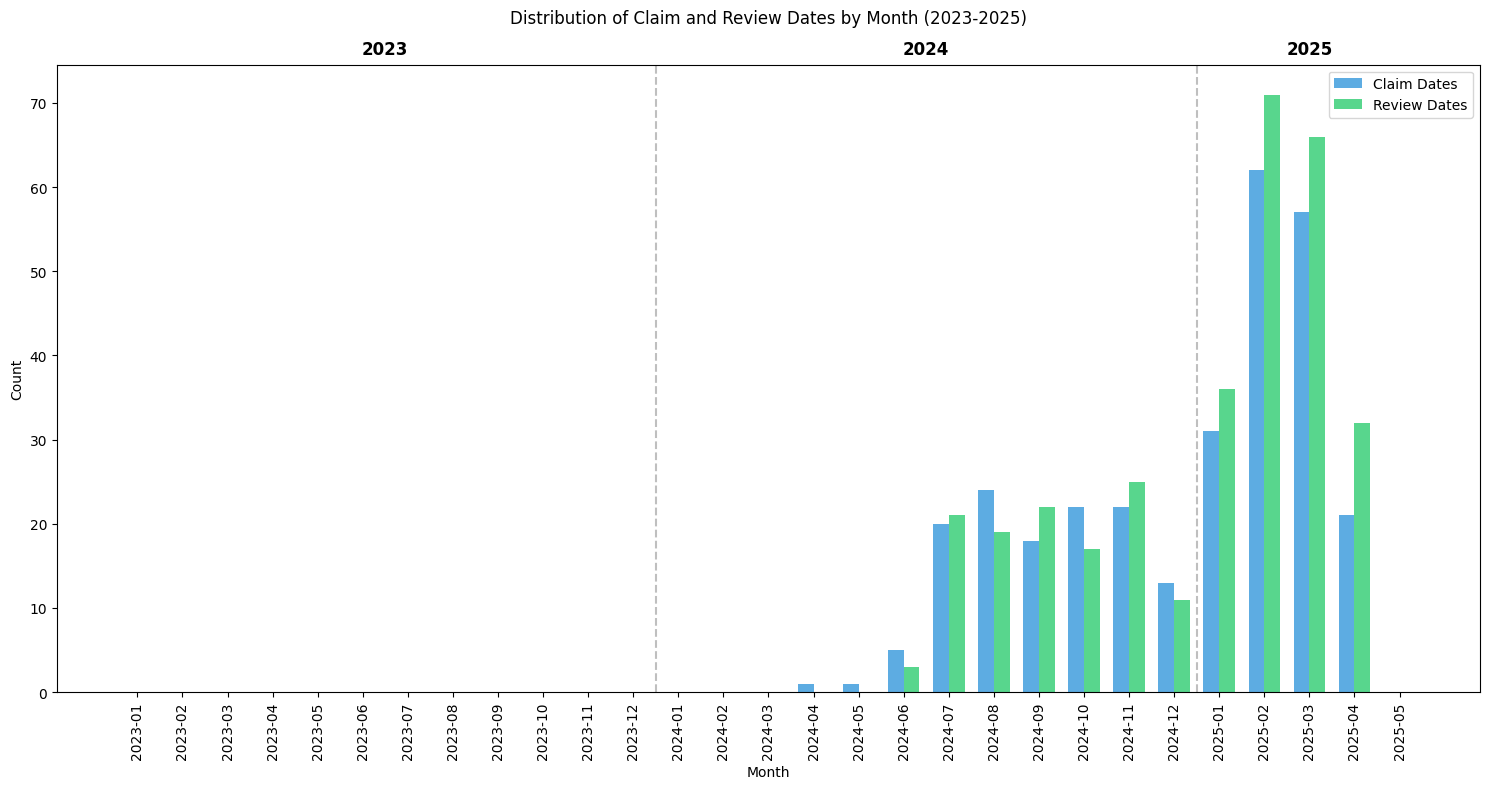

In [148]:
plot_monthly_distribution(df_ukraine)

In [149]:
claim_counts = df_ukraine.groupby(['claim_year', 'claim_month']).size().reset_index(name="count")
claim_counts

claim_year  claim_month  count
0       2022.0          2.0      1
1       2022.0          3.0      1
2       2022.0          8.0      1
3       2024.0          4.0      1
4       2024.0          5.0      1
5       2024.0          6.0      5
6       2024.0          7.0     20
7       2024.0          8.0     24
8       2024.0          9.0     18
9       2024.0         10.0     22
10      2024.0         11.0     22
11      2024.0         12.0     13
12      2025.0          1.0     31
13      2025.0          2.0     62
14      2025.0          3.0     57
15      2025.0          4.0     21
16      2025.0         12.0      1

- There are 3 claims in 2022 -> filtering them out
- There are 7 claims in 01-06/2024 -> filtering them out 
- There is 1 claims in 12/2025 (which does not make sense) -> filtering it out

In [150]:
json_filtered_date = filter_claims(data)

Original number of claims: 340
Claims removed due to missing claimDate: 39
Claims removed with claimDate before July 2024: 10
Claims removed with claimDate after April 2025: 1
Final numer of claims after filtering: 290
Distribution of remaining claims by year-month:
claimDate
2024-07    20
2024-08    24
2024-09    18
2024-10    22
2024-11    22
2024-12    13
2025-01    31
2025-02    62
2025-03    57
2025-04    21
Name: count, dtype: int64


In [151]:
# Checking that the filtering worked
print(len(json_filtered_date["claims"]))

json_filtered_date

290


{'query': 'Ukraine',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'A video shows Russian president Vladimir Putin laughing with his face in his hands during a comedy routine in which Volodymyr Zelenskyy appears to play the piano with his penis, before he became president of Ukraine.',
   'claimant': 'Instagram user',
   'claimDate': '2025-04-13T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfact.org'},
     'url': 'https://fullfact.org/online/Zelenskyy-performing-for-Putin-false/',
     'title': 'Clip does not show Zelenskyy performing comedy routine for Putin – Full Fact',
     'reviewDate': '2025-04-30T00:00:00Z',
     'textualRating': 'False. These two clips are from different events and have been edited together to misleadingly make it appear as if President Putin was in the audience for the routine.',
     'languageCode': 'en'}],
   'index': 0},
  {'text': 'After Prince Harry visited Ukraine, the video with th

### 2) Remove claims with videos

In [152]:
find_claims_with_videos(json_filtered_date)

Found 74 claims containing 'video' in text or title
Indices of claims with video: [0, 1, 3, 4, 8, 26, 36, 40, 46, 48, 49, 50, 51, 52, 56, 58, 59, 62, 63, 66, 68, 69, 70, 72, 77, 78, 79, 80, 83, 94, 96, 98, 101, 112, 113, 118, 129, 141, 142, 160, 184, 201, 206, 218, 221, 228, 231, 239, 242, 255, 256, 264, 269, 273, 275, 276, 279, 280, 283, 285, 286, 290, 298, 300, 302, 306, 307, 312, 313, 314, 315, 319, 320, 324]


[{'text': 'A video shows Russian president Vladimir Putin laughing with his face in his hands during a comedy routine in which Volodymyr Zelenskyy appears to play the piano with his penis, before he became president of Ukraine.',
  'claimant': 'Instagram user',
  'claimDate': '2025-04-13T00:00:00Z',
  'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfact.org'},
    'url': 'https://fullfact.org/online/Zelenskyy-performing-for-Putin-false/',
    'title': 'Clip does not show Zelenskyy performing comedy routine for Putin – Full Fact',
    'reviewDate': '2025-04-30T00:00:00Z',
    'textualRating': 'False. These two clips are from different events and have been edited together to misleadingly make it appear as if President Putin was in the audience for the routine.',
    'languageCode': 'en'}],
  'index': 0},
 {'text': 'After Prince Harry visited Ukraine, the video with the BBC logo spread online. The video tells that a boy with burns, with whom a member of the British royal 

In [153]:
json_filtered_date_videos = filter_out_video_claims(json_filtered_date)

Found 74 claims containing 'video' in text or title
Indices of claims with video: [0, 1, 129, 3, 4, 256, 8, 264, 141, 142, 269, 273, 275, 276, 279, 280, 26, 283, 285, 286, 160, 290, 36, 40, 298, 300, 46, 302, 48, 49, 50, 51, 52, 306, 307, 56, 184, 58, 59, 312, 313, 62, 63, 314, 315, 66, 319, 68, 69, 70, 320, 72, 201, 324, 77, 78, 79, 80, 206, 83, 218, 221, 94, 96, 98, 228, 101, 231, 239, 112, 113, 242, 118, 255]
Original number of claims: 290
Remaining claims after filtering: 216


In [154]:
# Checking that filtering worked
print(len(json_filtered_date_videos["claims"]))

json_filtered_date_videos

216


{'query': 'Ukraine',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Hotline for Complaints About «Loud Ukrainian Refugees» Set Up Lisbon',
   'claimant': 'Viral social media post',
   'claimDate': '2025-04-20T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'StopFake', 'site': 'stopfake.org'},
     'url': 'https://www.stopfake.org/en/fake-hotline-for-complaints-about-loud-ukrainian-refugees-set-up-lisbon/',
     'title': 'Fake: Hotline for Complaints About «Loud Ukrainian Refugees» Set Up Lisbon',
     'reviewDate': '2025-04-29T00:00:00Z',
     'textualRating': 'There is no evidence that such ads were posted in Lisbon.',
     'languageCode': 'en'}],
   'index': 2},
  {'text': 'Zelensky Will Force Partners to Pay for Disposing Obsolete Military Equipment They Gave Ukraine',
   'claimant': 'Michał Jarmoliński',
   'claimDate': '2025-04-22T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'StopFake', 'site': 'stopfake.org'},
     'url': 'http

### 3) Remove all claims from AFP Factcheck, Reuters, Snopes and Politifact

In [155]:
json_filtered_date_videos_urls = filter_claims_by_websites(json_filtered_date_videos)

Found 23 claims with target fact-checking websites.
{'text': 'An image shows a BBC News graphic naming Ukraine\'s "next president"', 'claimant': 'Multiple people', 'claimDate': '2025-03-31T00:00:00Z', 'claimReview': [{'publisher': {'name': 'AFP Fact Check', 'site': 'factcheck.afp.com'}, 'url': 'https://factcheck.afp.com/doc.afp.com.42BV3CV', 'title': 'Alleged BBC News chyron on Ukrainian presidency is fake', 'reviewDate': '2025-04-15T17:54:00Z', 'textualRating': 'Altered picture', 'languageCode': 'en'}], 'index': 15}
{'text': 'Putin says no ceasefire with Ukraine unless Duterte is freed from ICC.', 'claimant': 'Multiple sources', 'claimDate': '2025-03-16T00:00:00Z', 'claimReview': [{'publisher': {'name': 'AFP Fact Check', 'site': 'factcheck.afp.com'}, 'url': 'https://factcheck.afp.com/doc.afp.com.38MD3WD', 'title': "Fabricated news article frames Duterte's arrest as obstacle to Russia-Ukraine ceasefire", 'reviewDate': '2025-04-04T06:04:00Z', 'textualRating': 'False', 'languageCode': 'e

In [156]:
#Verify the length of the json and manually inspect the json to ensure the filtering was successful
print(len(json_filtered_date_videos_urls["claims"])) 
json_filtered_date_videos_urls

193


{'query': 'Ukraine',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Hotline for Complaints About «Loud Ukrainian Refugees» Set Up Lisbon',
   'claimant': 'Viral social media post',
   'claimDate': '2025-04-20T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'StopFake', 'site': 'stopfake.org'},
     'url': 'https://www.stopfake.org/en/fake-hotline-for-complaints-about-loud-ukrainian-refugees-set-up-lisbon/',
     'title': 'Fake: Hotline for Complaints About «Loud Ukrainian Refugees» Set Up Lisbon',
     'reviewDate': '2025-04-29T00:00:00Z',
     'textualRating': 'There is no evidence that such ads were posted in Lisbon.',
     'languageCode': 'en'}],
   'index': 2},
  {'text': 'Zelensky Will Force Partners to Pay for Disposing Obsolete Military Equipment They Gave Ukraine',
   'claimant': 'Michał Jarmoliński',
   'claimDate': '2025-04-22T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'StopFake', 'site': 'stopfake.org'},
     'url': 'http

### 4) Remove claims that don't have a clear, short label (maximum of 3 words/tokens)

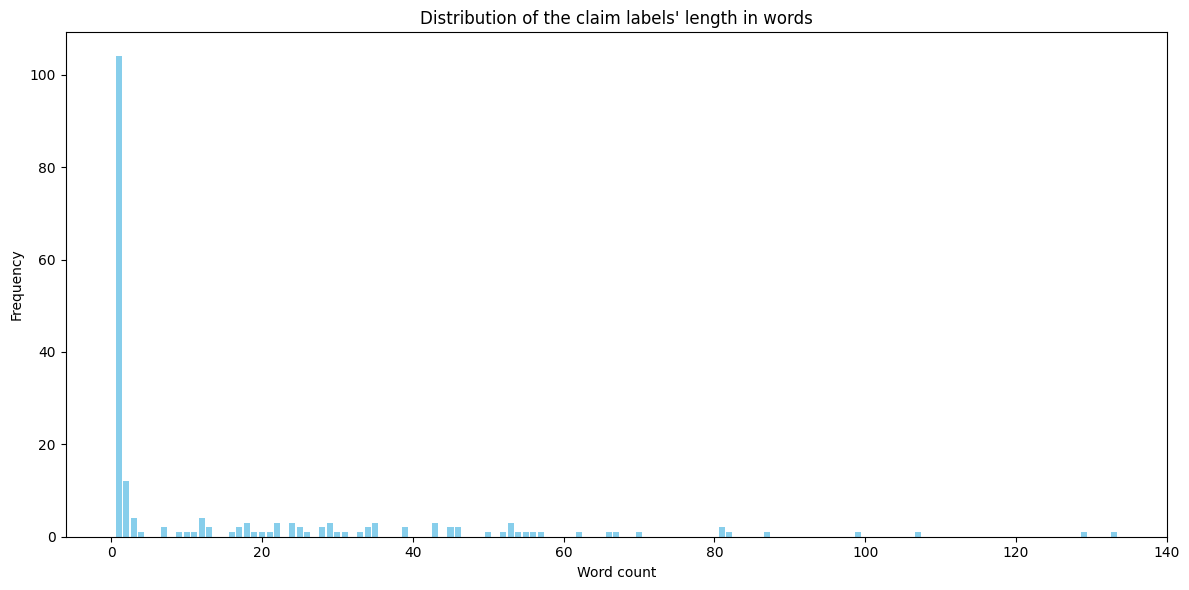

In [157]:
visualize_textual_ratings_length(json_filtered_date_videos_urls)

In [158]:
json_filtered_date_videos_urls_labels = filter_claims_by_label_length(json_filtered_date_videos_urls, max_words = 3)

# Checking the length of the claims and manually inspecting it to make sure the filtering was done correctly
print(len(json_filtered_date_videos_urls_labels["claims"]))
json_filtered_date_videos_urls_labels

Removed 73 claims whose labels are longer than 3 words
Kept 120 claims whose labels are of 3 or fewer words
120


{'query': 'Ukraine',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': "BBC News chyron naming Valerii Zaluzhnyi as 'Ukraine's next president.'",
   'claimant': 'X, Facebook',
   'claimDate': '2025-04-01T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Logically Facts',
      'site': 'logicallyfacts.com'},
     'url': 'https://www.logicallyfacts.com/en/fact-check/bbc-news-did-not-say-zaluzhny-the-next-president-of-ukraine-is-fake',
     'title': "No, this isn't a real BBC News broadcast about Valerii Zaluzhny",
     'reviewDate': '2025-04-22T00:00:00Z',
     'textualRating': 'Fake',
     'languageCode': 'en'}],
   'index': 9},
  {'text': 'Trump & Netanyahu are Planning on Resettling Gazans in Ukraine or Syria',
   'claimant': 'Facebook,Twitter',
   'claimDate': '2025-04-15T11:01:51Z',
   'claimReview': [{'publisher': {'name': 'The Quint', 'site': 'thequint.com'},
     'url': 'https://www.thequint.com/news/webqoof/trump-netanyahu-gaza-immigrants-u

### 5) Remove duplicates within the jsons 

- exact duplicates
- non-exact duplicates (same content, but claims are formulated differently)
  - manual inspection
  - prompting LLMs (using in-context learning examples -> 1 True, 1 False)
  - embedding-based approach (LLMs)

#### 5.1) Remove exact duplicates

In [159]:
json_filtered_date_videos_urls_labels_duplic_exact = remove_exact_duplicate_claims(json_filtered_date_videos_urls_labels)

#Verify the length of the json and manually inspect the json to ensure the filtering was successful
print(len(json_filtered_date_videos_urls_labels_duplic_exact["claims"])) 
json_filtered_date_videos_urls_labels_duplic_exact

Found 16 duplicate claims:
Donald Trump Jr. stated that he did not understand why anyone would choose Ukraine as an ally over Russia on his Triggered podcast.
Donald Trump just said that Ukraine started the war.
"[T]he figures announced with regard to losses on both sides, it is obvious that they were presented in the Ukrainian interpretation … Ukraine’s losses are multiple times higher than those of Russia.”
"…it was not Russia's actions that precipitated the escalation in Ukraine, but rather the 2014 coup d’etat, supported primarily by the United States. It was even publicly disclosed how much financial support the then U.S. administration allocated toward preparing and orchestrating this coup.”
This picture shows Ukraine’s President Volodymyr Zelenskyy refusing to shake hands with the UN Secretary-General António Guterres.
https://x.com/ricwe123/status/1858389133401461184
Did Pete Hegseth call Putin a 'war criminal'?
“This [North Korean troop deployment to Russia's war in Ukraine] s

{'query': 'Ukraine',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': "BBC News chyron naming Valerii Zaluzhnyi as 'Ukraine's next president.'",
   'claimant': 'X, Facebook',
   'claimDate': '2025-04-01T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Logically Facts',
      'site': 'logicallyfacts.com'},
     'url': 'https://www.logicallyfacts.com/en/fact-check/bbc-news-did-not-say-zaluzhny-the-next-president-of-ukraine-is-fake',
     'title': "No, this isn't a real BBC News broadcast about Valerii Zaluzhny",
     'reviewDate': '2025-04-22T00:00:00Z',
     'textualRating': 'Fake',
     'languageCode': 'en'}],
   'index': 9},
  {'text': 'Trump & Netanyahu are Planning on Resettling Gazans in Ukraine or Syria',
   'claimant': 'Facebook,Twitter',
   'claimDate': '2025-04-15T11:01:51Z',
   'claimReview': [{'publisher': {'name': 'The Quint', 'site': 'thequint.com'},
     'url': 'https://www.thequint.com/news/webqoof/trump-netanyahu-gaza-immigrants-u

In [160]:
# Saving the filtered Israel json 

output_directory = "../ukraine_russia/API_data_collection/"
output_filename = "claims_ukraine_010724_040525_filtered_104_claims.json"

output_path = os.path.join(output_directory, output_filename)


with open(output_path, "w", encoding = "utf-8") as f:
    json.dump(json_filtered_date_videos_urls_labels_duplic_exact, f, ensure_ascii=False, indent=4)


## 4) Russia

### 1) Remove claims after April, 30th, 2025 and (if availabe) before July, 1st, 2024

In [161]:
file_path = "../ukraine_russia/API_data_collection/claims_russia_010724_040525_249_claims.json"

try:
    with open(file_path, "r", encoding = "utf-8") as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

In [162]:
data

{'query': 'Russia',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': "According to Der Spiegel, German intelligence have just arrested two suspected Russia spies who had US defence secretary Pete Hegseth's private phone number in their mobiles.",
   'claimant': 'threads user',
   'claimDate': '2025-04-26T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfact.org'},
     'url': 'https://fullfact.org/news/hegseth-phone-number-spies-claim-der-spiegel-false/',
     'title': 'German news outlet did not report Russian spies had US defence secretary’s phone number – Full Fact',
     'reviewDate': '2025-04-30T00:00:00Z',
     'textualRating': 'A spokesperson for Der Spiegel confirmed it did not publish such a story.',
     'languageCode': 'en'}]},
  {'text': "German intelligence services arrested two alleged Russian spies who had U.S. Secretary of Defense Pete Hegseth's private number stored in their cellphones.",
   'claimReview

In [163]:
df_russia = extract_claim_and_reviewDate_from_json_transform_to_df(json_data = data)

Checking data types for a sample of the data:

Item 1:
  claimDate: 2025-04-26T00:00:00Z (Type: str)
  reviewDate: 2025-04-30T00:00:00Z (Type: str)

Item 2:
  claimDate: None (Type: NoneType)
  reviewDate: 2025-04-29T13:30:22Z (Type: str)

Item 3:
  claimDate: 2025-04-14T10:00:00Z (Type: str)
  reviewDate: 2025-04-29T19:40:05Z (Type: str)

Item 4:
  claimDate: 2025-04-25T08:39:09Z (Type: str)
  reviewDate: 2025-04-25T08:39:09Z (Type: str)

Item 5:
  claimDate: None (Type: NoneType)
  reviewDate: 2025-04-24T00:00:00Z (Type: str)

Length of dataframe:
249

Checking data types again:
claimDate     object
reviewDate    object
dtype: object

NA Values in claim and reviewDate:
claimDate     27
reviewDate    13
dtype: int64

Data types after conversion:
claimDate     datetime64[ns, UTC]
reviewDate    datetime64[ns, UTC]
dtype: object

Missing values after conversion:
claimDate     27
reviewDate    13
dtype: int64


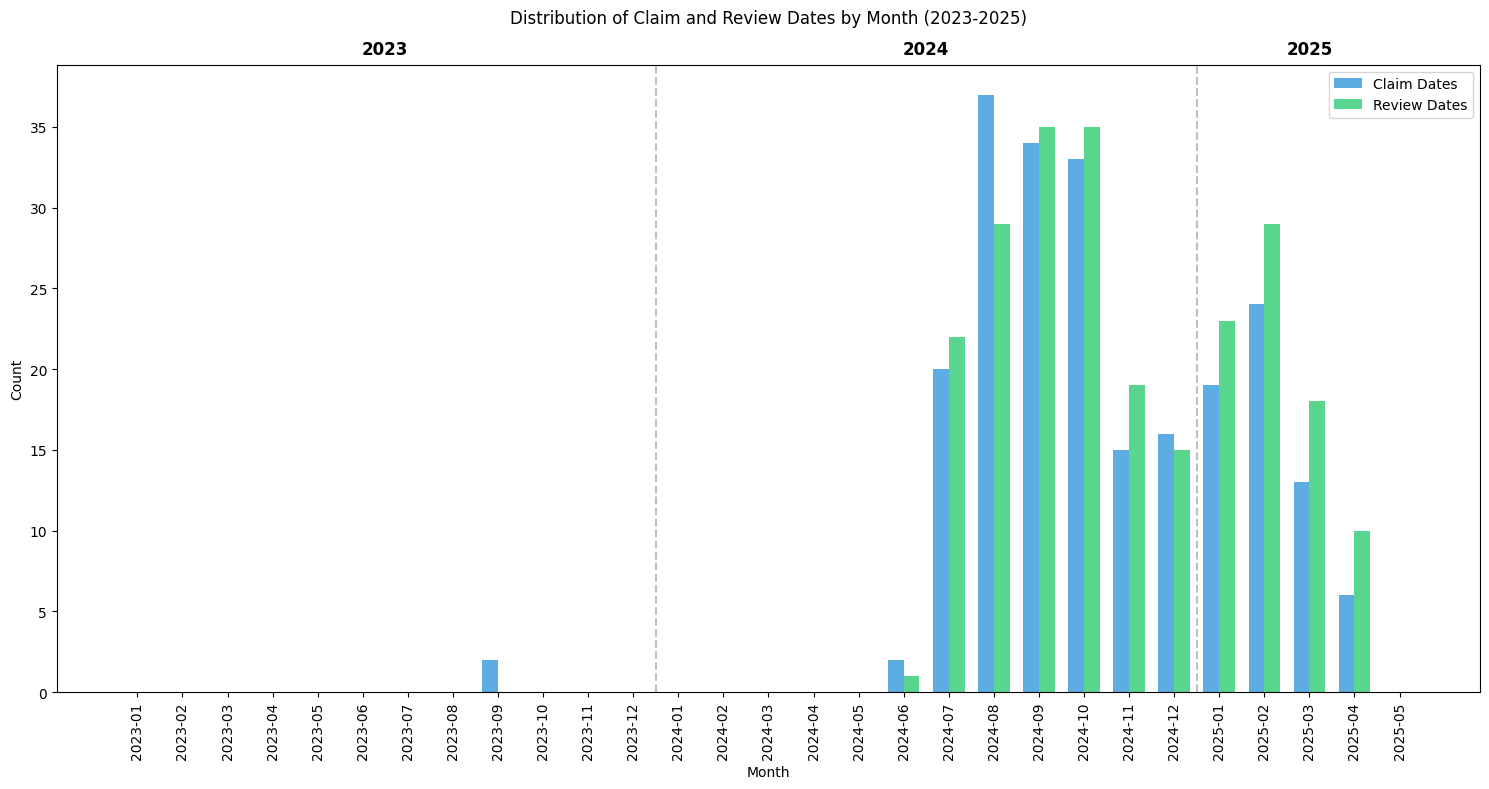

In [164]:
plot_monthly_distribution(df_russia)

In [165]:
claim_counts = df_russia.groupby(['claim_year', 'claim_month']).size().reset_index(name="count")
claim_counts

claim_year  claim_month  count
0       2023.0          9.0      2
1       2024.0          6.0      2
2       2024.0          7.0     20
3       2024.0          8.0     37
4       2024.0          9.0     34
5       2024.0         10.0     33
6       2024.0         11.0     15
7       2024.0         12.0     16
8       2025.0          1.0     19
9       2025.0          2.0     24
10      2025.0          3.0     13
11      2025.0          4.0      6
12      2025.0         12.0      1

- There are 2 claims in 2023 -> filtering them out
- There are 2 claims in 01-06/2024 -> filtering them out 
- There is 1 claims in 12/2025 (which does not make sense) -> filtering it out

In [166]:
json_filtered_date = filter_claims(data)

Original number of claims: 249
Claims removed due to missing claimDate: 27
Claims removed with claimDate before July 2024: 4
Claims removed with claimDate after April 2025: 1
Final numer of claims after filtering: 217
Distribution of remaining claims by year-month:
claimDate
2024-07    20
2024-08    37
2024-09    34
2024-10    33
2024-11    15
2024-12    16
2025-01    19
2025-02    24
2025-03    13
2025-04     6
Name: count, dtype: int64


In [167]:
# Checking that the filtering worked
print(len(json_filtered_date["claims"]))

json_filtered_date

217


{'query': 'Russia',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': "According to Der Spiegel, German intelligence have just arrested two suspected Russia spies who had US defence secretary Pete Hegseth's private phone number in their mobiles.",
   'claimant': 'threads user',
   'claimDate': '2025-04-26T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfact.org'},
     'url': 'https://fullfact.org/news/hegseth-phone-number-spies-claim-der-spiegel-false/',
     'title': 'German news outlet did not report Russian spies had US defence secretary’s phone number – Full Fact',
     'reviewDate': '2025-04-30T00:00:00Z',
     'textualRating': 'A spokesperson for Der Spiegel confirmed it did not publish such a story.',
     'languageCode': 'en'}],
   'index': 0},
  {'text': 'A BBC report reveals a Russian missile victim who met Prince Harry is a fraud.',
   'claimant': 'Facebook users',
   'claimDate': '2025-04-14T10:00:00Z',
   '

### 2) Remove claims with videos

In [168]:
find_claims_with_videos(json_filtered_date)

Found 44 claims containing 'video' in text or title
Indices of claims with video: [3, 17, 18, 23, 28, 29, 39, 69, 97, 105, 113, 118, 120, 133, 139, 145, 157, 162, 165, 166, 167, 173, 174, 175, 176, 180, 183, 186, 187, 189, 191, 192, 193, 195, 197, 208, 216, 219, 220, 233, 235, 241, 243, 246]


[{'text': 'Russia is basically getting nuked by Ukraine. The ammo depots, not innocent civilians like Russians do.',
  'claimant': 'x.com',
  'claimDate': '2025-04-25T08:39:09Z',
  'claimReview': [{'publisher': {'site': 'misbar.com'},
    'url': 'https://www.misbar.com/en/factcheck/2025/04/25/video-does-not-show-nuclear-explosion-russia',
    'title': 'This Video Does Not Show a Nuclear Explosion in Russia',
    'reviewDate': '2025-04-25T08:39:09Z',
    'textualRating': 'misleading',
    'languageCode': 'en'}],
  'index': 3},
 {'text': '2022 video of Ukrainian marines surrendering in Mariupol falsely shared as recent incident from Kursk region of Russia',
  'claimant': 'PTI Fact Check',
  'claimDate': '2025-03-18T12:03:39Z',
  'claimReview': [{'publisher': {'name': 'PTI', 'site': 'ptinews.com'},
    'url': 'https://www.ptinews.com/fact-detail/pti-fact-check-2022-video-of-ukrainian-marines-surrendering-in-mariupol-falsely-shared-as-recent-incident-from-kursk-region-of-russia/2382654',
 

In [169]:
json_filtered_date_videos = filter_out_video_claims(json_filtered_date)

Found 44 claims containing 'video' in text or title
Indices of claims with video: [3, 133, 139, 17, 18, 145, 23, 28, 157, 29, 162, 165, 166, 39, 167, 173, 174, 175, 176, 180, 183, 186, 187, 189, 191, 192, 193, 195, 69, 197, 208, 216, 219, 220, 97, 105, 233, 235, 113, 241, 243, 118, 246, 120]
Original number of claims: 217
Remaining claims after filtering: 173


In [170]:
# Checking that filtering worked
print(len(json_filtered_date_videos["claims"]))

json_filtered_date_videos

173


{'query': 'Russia',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': "According to Der Spiegel, German intelligence have just arrested two suspected Russia spies who had US defence secretary Pete Hegseth's private phone number in their mobiles.",
   'claimant': 'threads user',
   'claimDate': '2025-04-26T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfact.org'},
     'url': 'https://fullfact.org/news/hegseth-phone-number-spies-claim-der-spiegel-false/',
     'title': 'German news outlet did not report Russian spies had US defence secretary’s phone number – Full Fact',
     'reviewDate': '2025-04-30T00:00:00Z',
     'textualRating': 'A spokesperson for Der Spiegel confirmed it did not publish such a story.',
     'languageCode': 'en'}],
   'index': 0},
  {'text': 'A BBC report reveals a Russian missile victim who met Prince Harry is a fraud.',
   'claimant': 'Facebook users',
   'claimDate': '2025-04-14T10:00:00Z',
   '

### 3) Remove all claims from AFP Factcheck, Reuters, Snopes and Politifact

In [171]:
json_filtered_date_videos_urls = filter_claims_by_websites(json_filtered_date_videos)

Found 11 claims with target fact-checking websites.
{'text': 'Russia ends travel visas for all African countries', 'claimant': 'vellamfuphi', 'claimDate': '2025-03-13T00:00:00Z', 'claimReview': [{'publisher': {'name': 'AFP Fact Check', 'site': 'factcheck.afp.com'}, 'url': 'https://factcheck.afp.com/doc.afp.com.37TN8KD', 'title': 'Only six African countries enjoy visa-free entry to Russia, not all of them', 'reviewDate': '2025-03-26T11:50:00Z', 'textualRating': 'Misleading', 'languageCode': 'en'}], 'index': 11}
{'text': 'Putin presents BRICS banknote at recent summit', 'claimant': 'The Poll Lady', 'claimDate': '2024-08-23T00:00:00Z', 'claimReview': [{'publisher': {'name': 'AFP Fact Check', 'site': 'factcheck.afp.com'}, 'url': 'https://factcheck.afp.com/doc.afp.com.36L78UF', 'title': 'Posts misleadingly claim Russian leader unveiled BRICS banknote ...', 'reviewDate': '2024-11-01T11:27:00Z', 'textualRating': 'Misleading', 'languageCode': 'en'}], 'index': 127}
{'text': 'Putin presents BRIC

In [172]:
#Verify the length of the json and manually inspect the json to ensure the filtering was successful
print(len(json_filtered_date_videos_urls["claims"])) 
json_filtered_date_videos_urls

162


{'query': 'Russia',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': "According to Der Spiegel, German intelligence have just arrested two suspected Russia spies who had US defence secretary Pete Hegseth's private phone number in their mobiles.",
   'claimant': 'threads user',
   'claimDate': '2025-04-26T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'Full Fact', 'site': 'fullfact.org'},
     'url': 'https://fullfact.org/news/hegseth-phone-number-spies-claim-der-spiegel-false/',
     'title': 'German news outlet did not report Russian spies had US defence secretary’s phone number – Full Fact',
     'reviewDate': '2025-04-30T00:00:00Z',
     'textualRating': 'A spokesperson for Der Spiegel confirmed it did not publish such a story.',
     'languageCode': 'en'}],
   'index': 0},
  {'text': 'A BBC report reveals a Russian missile victim who met Prince Harry is a fraud.',
   'claimant': 'Facebook users',
   'claimDate': '2025-04-14T10:00:00Z',
   '

### 4) Remove claims that don't have a clear, short label (maximum of 3 words/tokens)

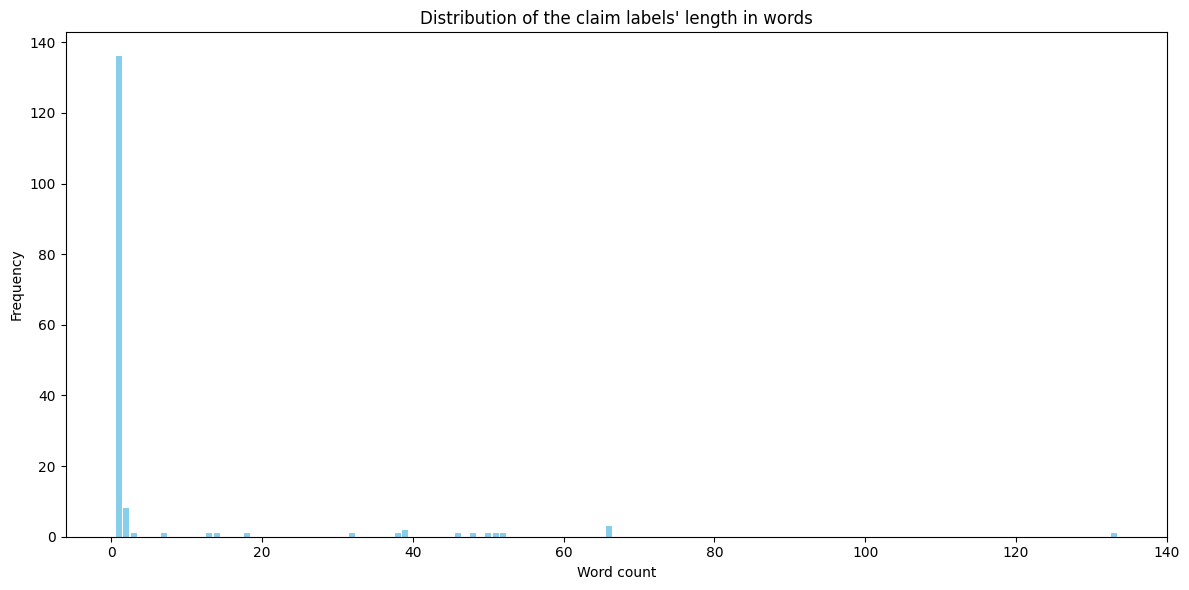

In [173]:
visualize_textual_ratings_length(json_filtered_date_videos_urls)

In [174]:
json_filtered_date_videos_urls_labels = filter_claims_by_label_length(json_filtered_date_videos_urls, max_words = 3)

# Checking the length of the claims and manually inspecting it to make sure the filtering was done correctly
print(len(json_filtered_date_videos_urls_labels["claims"]))
json_filtered_date_videos_urls_labels

Removed 17 claims whose labels are longer than 3 words
Kept 145 claims whose labels are of 3 or fewer words
145


{'query': 'Russia',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Russian President Vladimir Putin has died in an explosion in one of his limousines.',
   'claimant': 'Kaalam PH',
   'claimDate': '2025-04-17T06:49:48Z',
   'claimReview': [{'publisher': {'name': 'Rappler', 'site': 'rappler.com'},
     'url': 'https://www.rappler.com/newsbreak/fact-check/vladimir-putin-alive-not-dead-moscow-limousine-explosion/',
     'title': 'FACT CHECK: Putin is alive, not killed in Moscow limo explosion',
     'reviewDate': '2025-04-17T06:49:48Z',
     'textualRating': 'False',
     'languageCode': 'en'}],
   'index': 8},
  {'text': 'Russian President Vladimir Putin had sent a letter saying he will help former president Rodrigo Duterte be released from the ICC detention in The Hague, Netherlands.',
   'claimant': 'YouTube channel PINAS NEWS HEADLINES',
   'claimDate': '2025-04-06T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'VERA Files',
      'site': '

### 5) Remove duplicates within the jsons 

- exact duplicates
- non-exact duplicates (same content, but claims are formulated differently)
  - manual inspection
  - prompting LLMs (using in-context learning examples -> 1 True, 1 False)
  - embedding-based approach (LLMs)

#### 5.1) Remove exact duplicates

In [175]:
json_filtered_date_videos_urls_labels_duplic_exact = remove_exact_duplicate_claims(json_filtered_date_videos_urls_labels)

#Verify the length of the json and manually inspect the json to ensure the filtering was successful
print(len(json_filtered_date_videos_urls_labels_duplic_exact["claims"])) 
json_filtered_date_videos_urls_labels_duplic_exact

Found 34 duplicate claims:
“Trump threatened our president rather rudely, it must be said, pressuring to start the negotiations and reminding of Qaddafi’s fate.”
"Trump threatened our president rather rudely, it must be said, pressuring to start the negotiations and reminding of Gadhafi’s fate."
"Ukraine was gradually turning into a testing ground for experiments of any quality with biolabs, obviously with organ trading."
"[W]e need to continue to further expand military and military-technical cooperation with allies and partners who are ready and willing to work with us, which includes most countries around the world."
"Is it a coincidence that the Congo has become an experimental laboratory where populations have become guinea pigs to allow the World Health Organization, the #BillGates foundation, American European pharmaceutical firms and American biolabs to test viruses and other dirty things?"
"American newspapers, the bigwigs of the media business, refuse to support any candidate

{'query': 'Russia',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Russian President Vladimir Putin has died in an explosion in one of his limousines.',
   'claimant': 'Kaalam PH',
   'claimDate': '2025-04-17T06:49:48Z',
   'claimReview': [{'publisher': {'name': 'Rappler', 'site': 'rappler.com'},
     'url': 'https://www.rappler.com/newsbreak/fact-check/vladimir-putin-alive-not-dead-moscow-limousine-explosion/',
     'title': 'FACT CHECK: Putin is alive, not killed in Moscow limo explosion',
     'reviewDate': '2025-04-17T06:49:48Z',
     'textualRating': 'False',
     'languageCode': 'en'}],
   'index': 8},
  {'text': 'Russian President Vladimir Putin had sent a letter saying he will help former president Rodrigo Duterte be released from the ICC detention in The Hague, Netherlands.',
   'claimant': 'YouTube channel PINAS NEWS HEADLINES',
   'claimDate': '2025-04-06T00:00:00Z',
   'claimReview': [{'publisher': {'name': 'VERA Files',
      'site': '

In [176]:
# Saving the filtered Russia json 

output_directory = "../ukraine_russia/API_data_collection/"
output_filename = "claims_russia_010724_040525_filtered_111_claims.json"

output_path = os.path.join(output_directory, output_filename)


with open(output_path, "w", encoding = "utf-8") as f:
    json.dump(json_filtered_date_videos_urls_labels_duplic_exact, f, ensure_ascii=False, indent=4)


### Visualize label distributions of each of the filtered jsons 

In [2]:
file_path_gaza = "../gaza_israel/API_data_collection/API-fact-tools-google/claims_gaza_010724_040525_filtered_17_claims.json"
file_path_israel = "../gaza_israel/API_data_collection/API-fact-tools-google/claims_israel_010724_040525_filtered_88_claims.json"
file_path_ukraine = "../ukraine_russia/API_data_collection/claims_ukraine_010724_040525_filtered_104_claims.json"
file_path_russia = "../ukraine_russia/API_data_collection/claims_russia_010724_040525_filtered_111_claims.json"



# load gaza 
try:
    with open(file_path_gaza, "r", encoding = "utf-8") as f:
        gaza_filtered_json = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

# load israel 
try:
    with open(file_path_israel, "r", encoding = "utf-8") as f:
        israel_filtered_json = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")


#load ukraine
try:
    with open(file_path_ukraine, "r", encoding = "utf-8") as f:
        ukraine_filterd_json = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")


# load russia
try:
    with open(file_path_russia, "r", encoding = "utf-8") as f:
        russia_filtered_json = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")


In [3]:
gaza_filtered_json

{'query': 'Gaza',
 'after_date': '2024-07-01T00:00:00Z',
 'language_code': 'en',
 'claims': [{'text': 'Photo shows a Turkey-made bomb that was dropped on Gaza.',
   'claimant': 'x.com',
   'claimDate': '2025-04-18T14:37:44Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/04/18/image-does-not-show-debris-turkish-made-bomb-dropped-gaza',
     'title': 'Image Does Not Show Debris of Turkish-Made Bomb Dropped on Gaza',
     'reviewDate': '2025-04-18T14:37:44Z',
     'textualRating': 'misleading',
     'languageCode': 'en'}],
   'index': 3},
  {'text': 'Baby Sham did not lose her arm in an Israeli airstrike on the Shejaeya neighborhood, east of Gaza City.',
   'claimant': 'x.com',
   'claimDate': '2025-04-13T05:39:22Z',
   'claimReview': [{'publisher': {'site': 'misbar.com'},
     'url': 'https://www.misbar.com/en/factcheck/2025/04/13/contrary-trolls-baby-sham-lost-her-arm-and-died-israeli-airstrike',
     'title': 'Contrary t

In [15]:
def extract_labels(json_data):

    """ 
    This function extracts the textual ratings for each claim and stores it in a list 
    which are then used to visualize the label distribution of the claims.
    
    """

    labels = []

    for claim in json_data.get("claims", []):
        for review in claim.get("claimReview", []):
            textual_rating = review.get("textualRating", [])
            textual_rating_lowercase = textual_rating.lower() #lower case the labels
            labels.append(textual_rating_lowercase)

    return labels


def visualize_label_distribution(json_data):

    # Extract textual ratings

    labels = extract_labels(json_data)

    # # Convert to df for easier analysis 
    # df = pd.DataFrame(label_word_counts)

    # Count frequencies of word counts
    label_count_freq = Counter(labels)

    # Sort by word count for better visualization
    label_counts = sorted(label_count_freq.keys())
    frequencies = [label_count_freq[count] for count in label_counts]

    # Plot word count distribution
    plt.figure(figsize=(12,6))
    plt.bar(label_counts, frequencies, color="skyblue")
    plt.title("Distribution of the labels of the claims within each filtered json.")
    plt.xlabel("Label")
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")


    plt.tight_layout()
    plt.show()



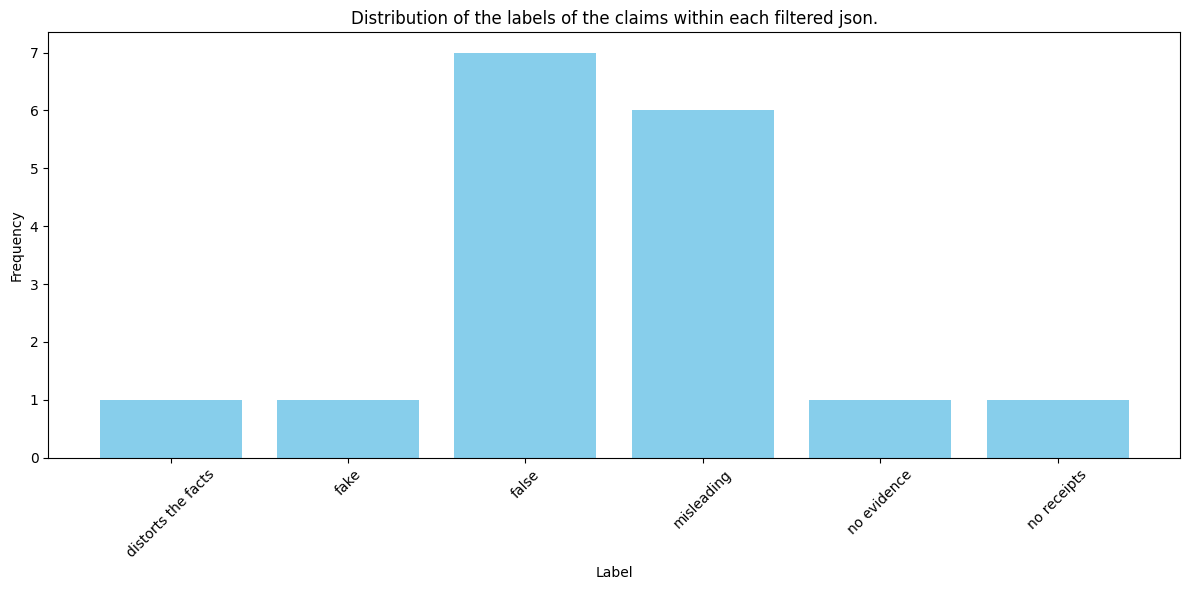

In [16]:
visualize_label_distribution(gaza_filtered_json)

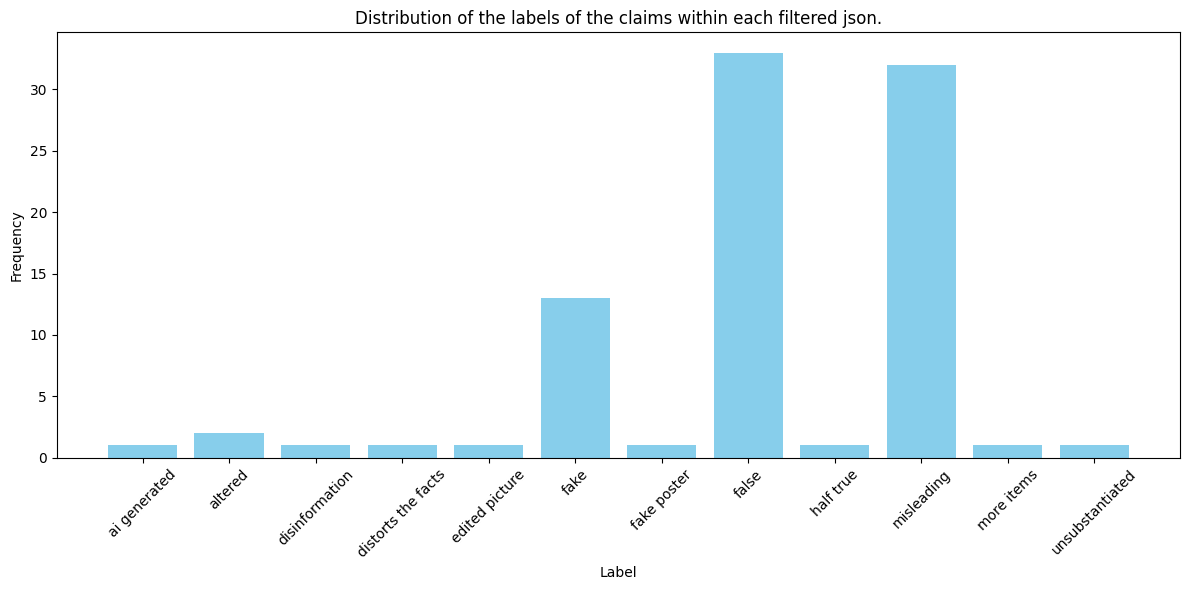

In [17]:
visualize_label_distribution(israel_filtered_json)

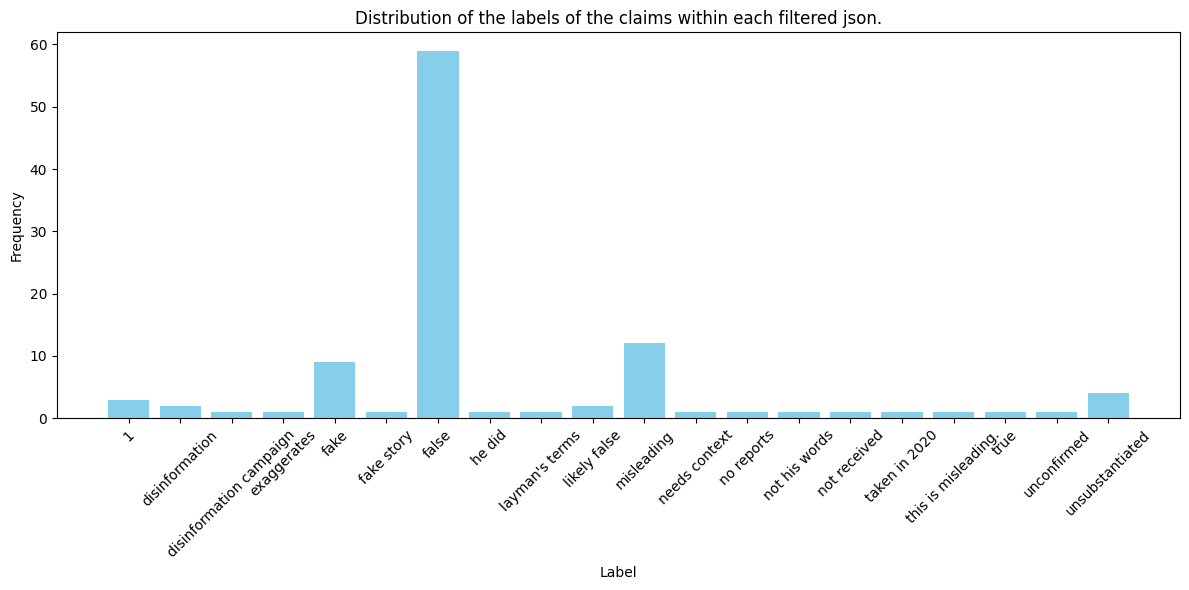

In [18]:
visualize_label_distribution(ukraine_filterd_json)

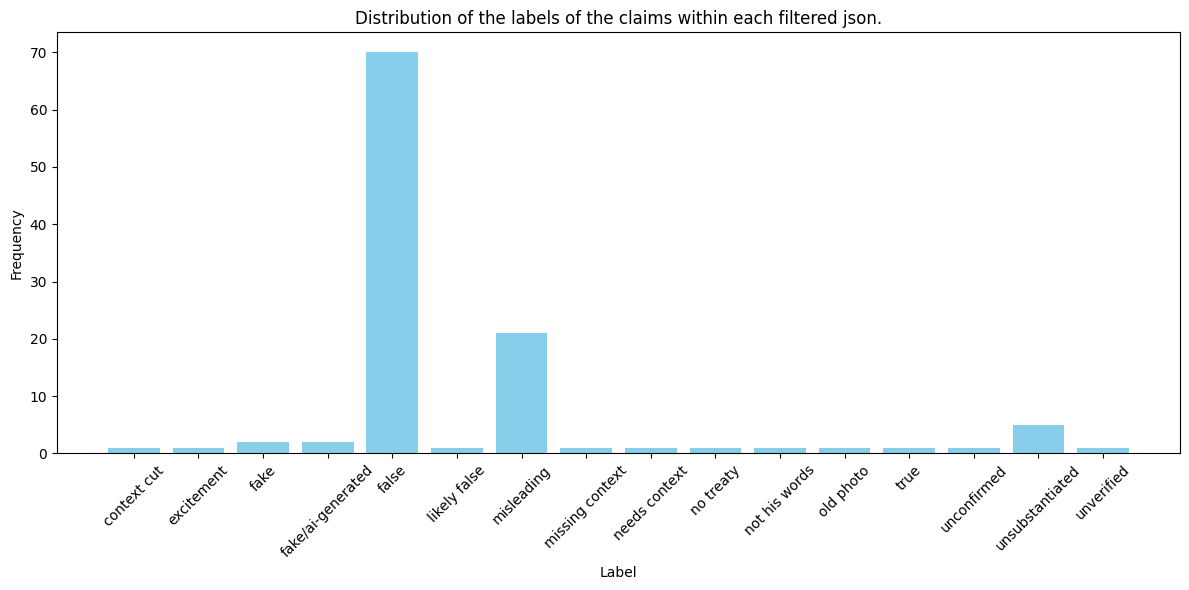

In [19]:
visualize_label_distribution(russia_filtered_json)